In [1]:
# AeroCNN-II with U-Net
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13937404970904896501
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11840846555937751818
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11593890418095797472
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 21426601984
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3626997284539339802
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6"
 xla_globa

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1", "/GPU:2"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [4]:
n_kernel=50
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [5]:
alpha = np.linspace(-10,10,11).reshape((-1,1))

In [6]:
aa = np.zeros((11*133,1))
for i in range(0, 133):
    aa[11*i:11*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 11, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133, 11, 100, 100))

In [14]:
image = 1-image/100

In [15]:
path = 'D:\\airfoilFlowField'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 0].values

In [17]:
data_name = path + '\\' + str(geometry_orig[0]) + "alpha"+ str(int(alpha[1])) + "_interpolated.csv"
print(data_name)

D:\airfoilFlowField\airfoil1alpha-8_interpolated.csv


In [18]:
Vmag_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        data_name = path + '\\' + str(geometry_orig[i]) + "alpha"+ str(int(alpha[j])) + "_interpolated.csv"
        data = pd.read_csv(data_name, header=None)
        Vmag_df = pd.concat([Vmag_df, data], axis=0)

In [19]:
geometry_orig = airfoilName_df.iloc[:, 1].values

In [20]:
y_imp = Vmag_df.iloc[:, :].values

In [21]:
y = y_imp.reshape((133, 11, n_grid, n_grid))

In [22]:
geometry = np.zeros((133*11,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,11):
        geometry[11*index_[0]+j,:] = np.asarray(i)

In [23]:
geometry.shape

(1463, 1)

In [24]:
geometry = geometry.reshape((133, 11, 1))

In [25]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [26]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [27]:
with mirrored_strategy.scope():
    input_image = tf.keras.Input(shape=(input_size, input_size, 1))

    x_conv_E = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                      activation='relu', padding='same',
                                      kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                      name='Conv2DLayer1')(input_image)
    x_pool_E = tf.keras.layers.MaxPooling2D((2,2))(x_conv_E)

    x_conv_D = tf.keras.layers.Conv2DTranspose(n_kernel, (kernel_size1, kernel_size1), strides = (2, 2),
                                         padding='same', activation='relu')(x_pool_E)
    x_concat = tf.concat([x_conv_E, x_conv_D], axis=-1)
    x_conv_Final = tf.keras.layers.Conv2D(1, (kernel_size1, kernel_size1), strides=(strides, strides),
                                          activation='relu', padding='same',
                                          kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                          name='Conv2DLayer2')(x_concat)
    reshape1 = tf.keras.layers.Flatten()(x_conv_Final)
    x_ = tf.keras.layers.Dense(units=n_grid*n_grid, activation=None, name='outputLayer',
                               kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)

    output_image = tf.keras.layers.Reshape((n_grid, n_grid, 1))(x_)
    # AeroCNN-II based
    model = tf.keras.Model(input_image, output_image)

In [28]:
with mirrored_strategy.scope():
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv2DLayer1 (Conv2D)          (None, 100, 100, 50  1300        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 50, 50, 50)   0           ['Conv2DLayer1[0][0]']           
                                                                                              

In [29]:
with mirrored_strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss = tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [30]:
with mirrored_strategy.scope():
    start = datetime.datetime.now()
    history = model.fit(x_train, y_train, epochs=5000, shuffle=True,callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30))
    end = datetime.datetime.now()

Epoch 1/5000
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1
44/44 [==============================] - 26s 145ms/step - loss: 4.1137 - rmse: 2.0282
Epoch 2/5000
44/44 [==============================] - 7s 151ms/step - loss: 0.1019 - rmse: 0.3192
Epoch 3/5000
44/44 [==============================] - 7s 157ms/step - loss: 0.0785 - rmse: 0.2802
Epoch 4/5000
44/44 [==============================] - 7s 169ms/step - loss: 0.0745 - rmse: 0.2730
Epoch 5/5000
44/44 [==============================] - 7s 148ms/step - loss: 0.0637 - rmse: 0.2523
Epoch 6/5000
44/44 [=============

44/44 [==============================] - 6s 148ms/step - loss: 0.0140 - rmse: 0.1184
Epoch 80/5000
44/44 [==============================] - 6s 146ms/step - loss: 0.0142 - rmse: 0.1192
Epoch 81/5000
44/44 [==============================] - 6s 145ms/step - loss: 0.0140 - rmse: 0.1183
Epoch 82/5000
44/44 [==============================] - 6s 147ms/step - loss: 0.0137 - rmse: 0.1172
Epoch 83/5000
44/44 [==============================] - 6s 144ms/step - loss: 0.0137 - rmse: 0.1168
Epoch 84/5000
44/44 [==============================] - 6s 144ms/step - loss: 0.0132 - rmse: 0.1146
Epoch 85/5000
44/44 [==============================] - 6s 146ms/step - loss: 0.0132 - rmse: 0.1147
Epoch 86/5000
44/44 [==============================] - 7s 148ms/step - loss: 0.0133 - rmse: 0.1154
Epoch 87/5000
44/44 [==============================] - 6s 146ms/step - loss: 0.0136 - rmse: 0.1165
Epoch 88/5000
44/44 [==============================] - 6s 146ms/step - loss: 0.0129 - rmse: 0.1134
Epoch 89/5000
44/44 [===

44/44 [==============================] - 6s 139ms/step - loss: 0.0073 - rmse: 0.0852
Epoch 244/5000
44/44 [==============================] - 6s 141ms/step - loss: 0.0075 - rmse: 0.0863
Epoch 245/5000
44/44 [==============================] - 6s 140ms/step - loss: 0.0073 - rmse: 0.0852
Epoch 246/5000
44/44 [==============================] - 6s 144ms/step - loss: 0.0073 - rmse: 0.0854
Epoch 247/5000
44/44 [==============================] - 6s 138ms/step - loss: 0.0074 - rmse: 0.0858
Epoch 248/5000
44/44 [==============================] - 6s 139ms/step - loss: 0.0074 - rmse: 0.0857
Epoch 249/5000
44/44 [==============================] - 6s 140ms/step - loss: 0.0072 - rmse: 0.0849
Epoch 250/5000
44/44 [==============================] - 6s 140ms/step - loss: 0.0072 - rmse: 0.0845
Epoch 251/5000
44/44 [==============================] - 6s 138ms/step - loss: 0.0074 - rmse: 0.0857
Epoch 252/5000
44/44 [==============================] - 6s 140ms/step - loss: 0.0072 - rmse: 0.0850
Epoch 253/5000


44/44 [==============================] - 6s 139ms/step - loss: 0.0058 - rmse: 0.0762
Epoch 326/5000
44/44 [==============================] - 6s 140ms/step - loss: 0.0059 - rmse: 0.0770
Epoch 327/5000
44/44 [==============================] - 6s 143ms/step - loss: 0.0059 - rmse: 0.0764
Epoch 328/5000
44/44 [==============================] - 6s 140ms/step - loss: 0.0062 - rmse: 0.0783
Epoch 329/5000
44/44 [==============================] - 6s 141ms/step - loss: 0.0065 - rmse: 0.0808
Epoch 330/5000
44/44 [==============================] - 6s 143ms/step - loss: 0.0062 - rmse: 0.0785
Epoch 331/5000
44/44 [==============================] - 6s 140ms/step - loss: 0.0060 - rmse: 0.0776
Epoch 332/5000
44/44 [==============================] - 6s 141ms/step - loss: 0.0062 - rmse: 0.0783
Epoch 333/5000
44/44 [==============================] - 6s 143ms/step - loss: 0.0063 - rmse: 0.0793
Epoch 334/5000
44/44 [==============================] - 6s 140ms/step - loss: 0.0060 - rmse: 0.0771
Epoch 335/5000


44/44 [==============================] - 6s 139ms/step - loss: 0.0047 - rmse: 0.0687
Epoch 408/5000
44/44 [==============================] - 6s 139ms/step - loss: 0.0049 - rmse: 0.0698
Epoch 409/5000
44/44 [==============================] - 6s 140ms/step - loss: 0.0048 - rmse: 0.0688
Epoch 410/5000
44/44 [==============================] - 6s 140ms/step - loss: 0.0049 - rmse: 0.0699
Epoch 411/5000
44/44 [==============================] - 6s 139ms/step - loss: 0.0049 - rmse: 0.0696
Epoch 412/5000
44/44 [==============================] - 6s 144ms/step - loss: 0.0046 - rmse: 0.0680
Epoch 413/5000
44/44 [==============================] - 6s 144ms/step - loss: 0.0047 - rmse: 0.0682
Epoch 414/5000
44/44 [==============================] - 6s 141ms/step - loss: 0.0046 - rmse: 0.0675
Epoch 415/5000
44/44 [==============================] - 6s 142ms/step - loss: 0.0049 - rmse: 0.0699
Epoch 416/5000
44/44 [==============================] - 6s 142ms/step - loss: 0.0048 - rmse: 0.0689
Epoch 417/5000


44/44 [==============================] - 6s 132ms/step - loss: 0.0043 - rmse: 0.0658
Epoch 490/5000
44/44 [==============================] - 6s 132ms/step - loss: 0.0042 - rmse: 0.0645
Epoch 491/5000
44/44 [==============================] - 6s 132ms/step - loss: 0.0039 - rmse: 0.0625
Epoch 492/5000
44/44 [==============================] - 6s 134ms/step - loss: 0.0040 - rmse: 0.0630
Epoch 493/5000
44/44 [==============================] - 6s 134ms/step - loss: 0.0040 - rmse: 0.0627
Epoch 494/5000
44/44 [==============================] - 6s 134ms/step - loss: 0.0039 - rmse: 0.0626
Epoch 495/5000
44/44 [==============================] - 6s 135ms/step - loss: 0.0041 - rmse: 0.0635
Epoch 496/5000
44/44 [==============================] - 6s 134ms/step - loss: 0.0039 - rmse: 0.0623
Epoch 497/5000
44/44 [==============================] - 6s 133ms/step - loss: 0.0039 - rmse: 0.0625
Epoch 498/5000
44/44 [==============================] - 6s 133ms/step - loss: 0.0040 - rmse: 0.0632
Epoch 499/5000


44/44 [==============================] - 6s 132ms/step - loss: 0.0035 - rmse: 0.0586
Epoch 572/5000
44/44 [==============================] - 6s 133ms/step - loss: 0.0034 - rmse: 0.0581
Epoch 573/5000
44/44 [==============================] - 6s 135ms/step - loss: 0.0032 - rmse: 0.0564
Epoch 574/5000
44/44 [==============================] - 6s 135ms/step - loss: 0.0033 - rmse: 0.0569
Epoch 575/5000
44/44 [==============================] - 6s 137ms/step - loss: 0.0038 - rmse: 0.0611
Epoch 576/5000
44/44 [==============================] - 6s 139ms/step - loss: 0.0036 - rmse: 0.0594
Epoch 577/5000
44/44 [==============================] - 6s 136ms/step - loss: 0.0033 - rmse: 0.0575
Epoch 578/5000
44/44 [==============================] - 6s 135ms/step - loss: 0.0034 - rmse: 0.0583
Epoch 579/5000
44/44 [==============================] - 6s 136ms/step - loss: 0.0036 - rmse: 0.0602
Epoch 580/5000
44/44 [==============================] - 6s 133ms/step - loss: 0.0033 - rmse: 0.0576
Epoch 581/5000


44/44 [==============================] - 7s 148ms/step - loss: 0.0033 - rmse: 0.0572
Epoch 654/5000
44/44 [==============================] - 7s 148ms/step - loss: 0.0032 - rmse: 0.0564
Epoch 655/5000
44/44 [==============================] - 6s 147ms/step - loss: 0.0031 - rmse: 0.0558
Epoch 656/5000
44/44 [==============================] - 6s 148ms/step - loss: 0.0034 - rmse: 0.0578
Epoch 657/5000
44/44 [==============================] - 6s 148ms/step - loss: 0.0032 - rmse: 0.0565
Epoch 658/5000
44/44 [==============================] - 6s 147ms/step - loss: 0.0033 - rmse: 0.0575
Epoch 659/5000
44/44 [==============================] - 6s 147ms/step - loss: 0.0032 - rmse: 0.0562
Epoch 660/5000
44/44 [==============================] - 6s 144ms/step - loss: 0.0030 - rmse: 0.0543
Epoch 661/5000
44/44 [==============================] - 6s 146ms/step - loss: 0.0032 - rmse: 0.0564
Epoch 662/5000
44/44 [==============================] - 7s 148ms/step - loss: 0.0054 - rmse: 0.0730
Epoch 663/5000


In [31]:
time = end - start
print("Training time:", time)

Training time: 1:08:31.563534


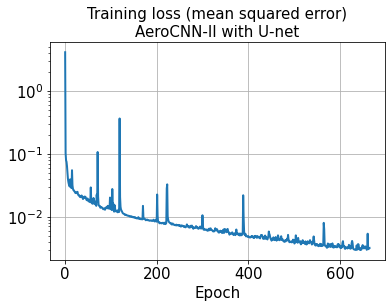

In [32]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II with U-net', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

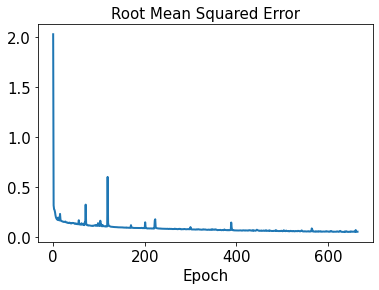

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

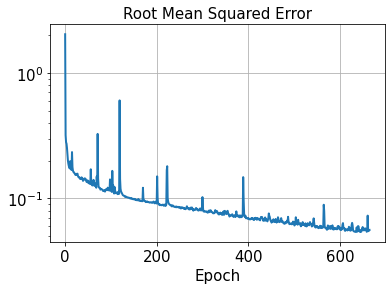

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [35]:
with mirrored_strategy.scope():
    test_results = model.evaluate(x_train)
    decoded_train = model.predict(x_train)
    decoded_test = model.predict(x_test)

3/3 [==============================] - 0s 45ms/step


In [36]:
test_results2 = model.evaluate(x_test)

3/3 [==============================] - 0s 7ms/step - loss: 2.4740e-05 - rmse: 0.0000e+00


In [37]:
y_train.shape

(1386, 101, 101)

In [38]:
y_train.shape[0]

1386

In [39]:
type(decoded_train.shape[3])

int

In [40]:
type(decoded_train)

numpy.ndarray

In [41]:
type(n_grid)

int

In [42]:
decoded_train = decoded_train.reshape((int(y_train.shape[0]),int(n_grid),int(n_grid)))
decoded_test = decoded_test.reshape((int(y_test.shape[0]),int(n_grid),int(n_grid)))

In [43]:
decoded_train.shape

(1386, 101, 101)

In [44]:
y_train.shape[0]

1386

In [45]:
error_train_abs = np.abs(decoded_train - y_train)

In [46]:
error_test_abs = np.abs(decoded_test - y_test)

In [47]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [48]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [49]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [50]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [51]:
decoded_train.shape

(1386, 101, 101)

In [52]:
os.chdir("D:\\TrainedModels")

In [53]:
os.chdir("D:\\TrainedModels\\20221019")
model.save('AeroCNN-II_with_U-net_FlowFieldPrediction_50kernel_2by2MaxPooling_1CNNlayer_testSize0.05(-10to10).h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [54]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.010620509449858595


In [55]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.018069750510053852


In [56]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.013120697971060642, 0.016700776642905858, 0.012249221389776839, 0.008699600182117124, 0.007522139940346537, 0.00803723946239993, 0.007577689051240106, 0.007442890756020284, 0.009678122762973723, 0.02260559835264406, 0.02463023068323304, 0.020987953235928374, 0.008374752914023415, 0.00893726365440428, 0.01031306558754413, 0.009350909767771235, 0.009017317481351293, 0.009595701117932997, 0.009398798838862969, 0.010320123374062878, 0.010214412794898063, 0.015114269935979351, 0.014689461960296985, 0.01828000635651788, 0.010971038987082134, 0.00917627757159121, 0.009564729358000653, 0.010665896769522442, 0.01084459054089134, 0.012856049200139887, 0.009777858704920763, 0.011198211646198919, 0.011009787752571694, 0.012238332437271363, 0.009918552654873061, 0.010792658189130538, 0.010244820231775979, 0.008862757964285133, 0.008782277715551167, 0.00888625714959731, 0.00795057210367382, 0.009105466285396975, 0.008058177021259234, 0.007989951897564353, 0.045168213083621525, 0.01079309537825509

In [57]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.013957751445941939, 0.012961876920256687, 0.008155540892596253, 0.008742110169944231, 0.00884665920911207, 0.00779999533827532, 0.008472952079331048, 0.008338558134659472, 0.008572606070629466, 0.01041946792177512, 0.05084535703750931, 0.016658226857882465, 0.014899075197590567, 0.016385024295345756, 0.016456324813442568, 0.016715120354462727, 0.015084042647494734, 0.015243650274155795, 0.013823125894062167, 0.015072969137265073, 0.015370163693615572, 0.01630414168540061, 0.01997352173271215, 0.013026692959585721, 0.01099970732721933, 0.011015119589124931, 0.01117332640374716, 0.010953368354110765, 0.01224986587901746, 0.012852261703981174, 0.013341966579011945, 0.01410873771002887, 0.04666147961147709, 0.03210628652769883, 0.01226597567226335, 0.0080770318934406, 0.007660181154748193, 0.007520598284403204, 0.007103019659108838, 0.007221959300802634, 0.007471071355177612, 0.013196662725766615, 0.01768813665351527, 0.03308932439347082, 0.036160437344804224, 0.017618037583851734, 0.01

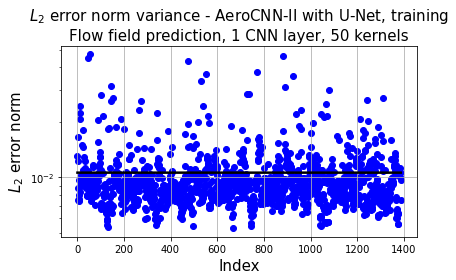

In [58]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II with U-Net, training\nFlow field prediction, 1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

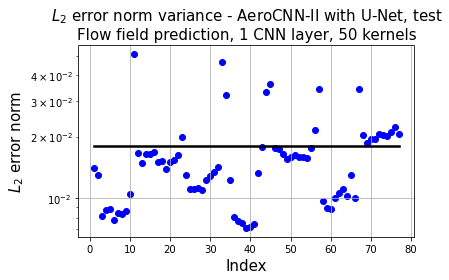

In [59]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II with U-Net, test\nFlow field prediction, 1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [79]:
os.chdir("D:\\AeroCNNII_Images\\20221019")

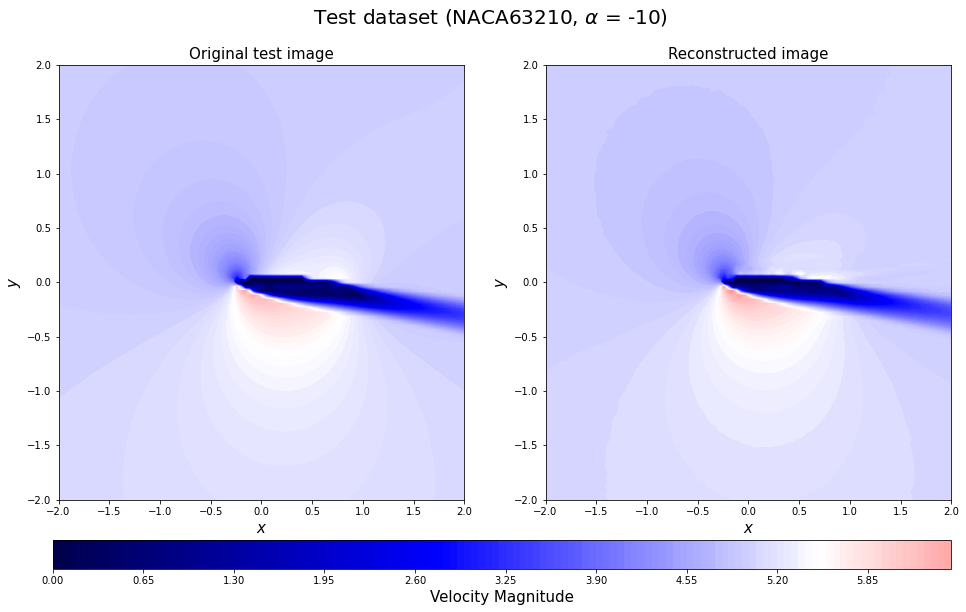

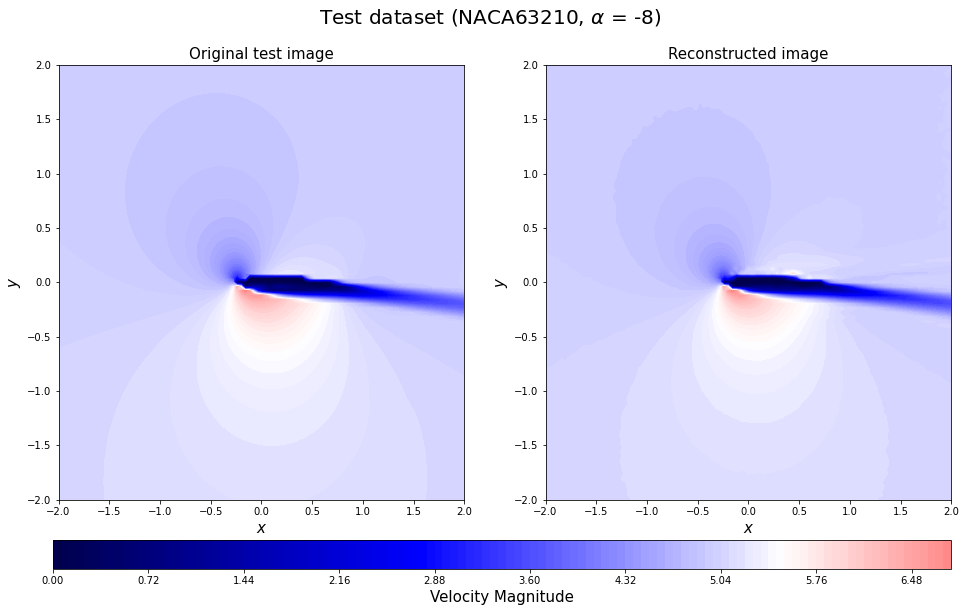

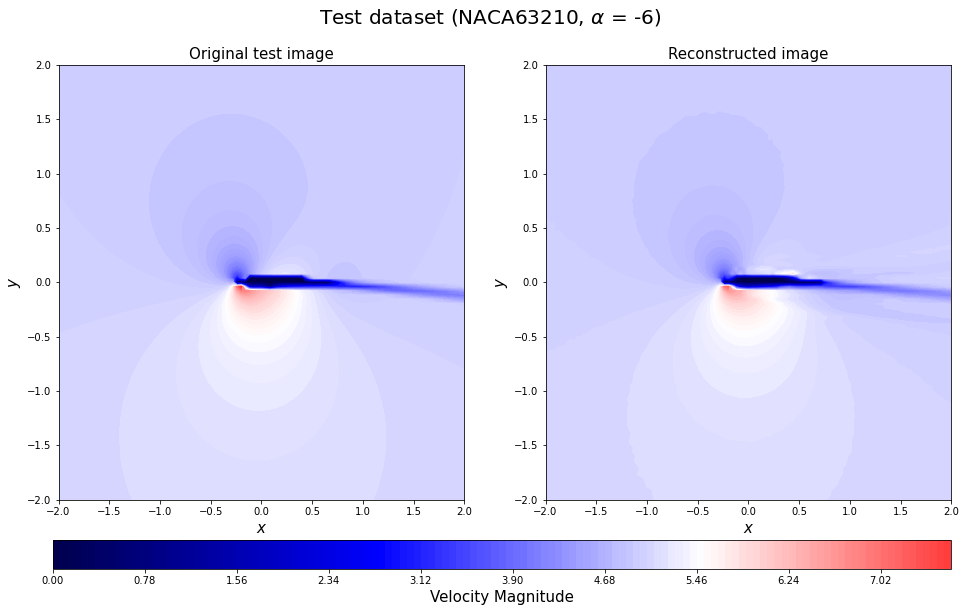

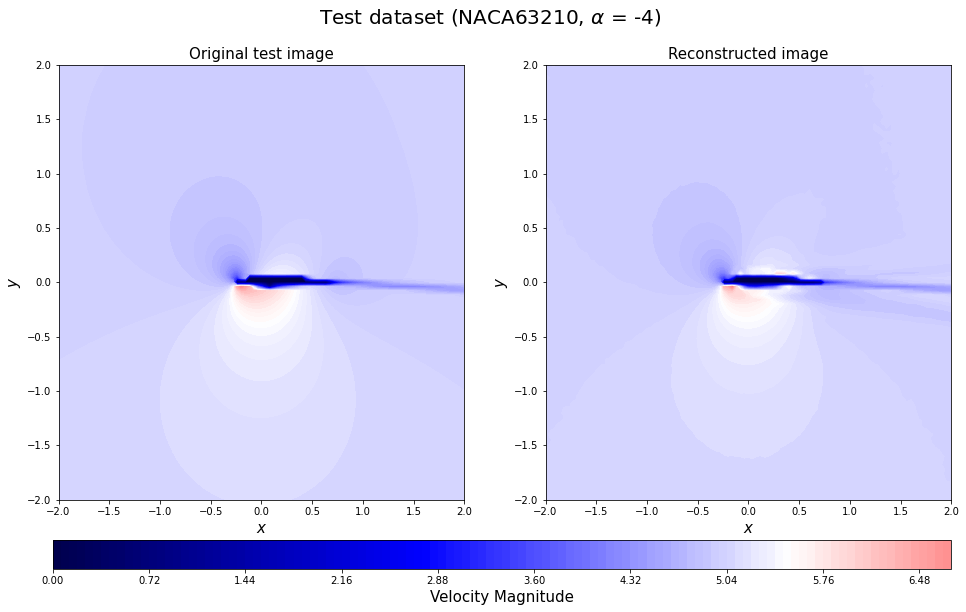

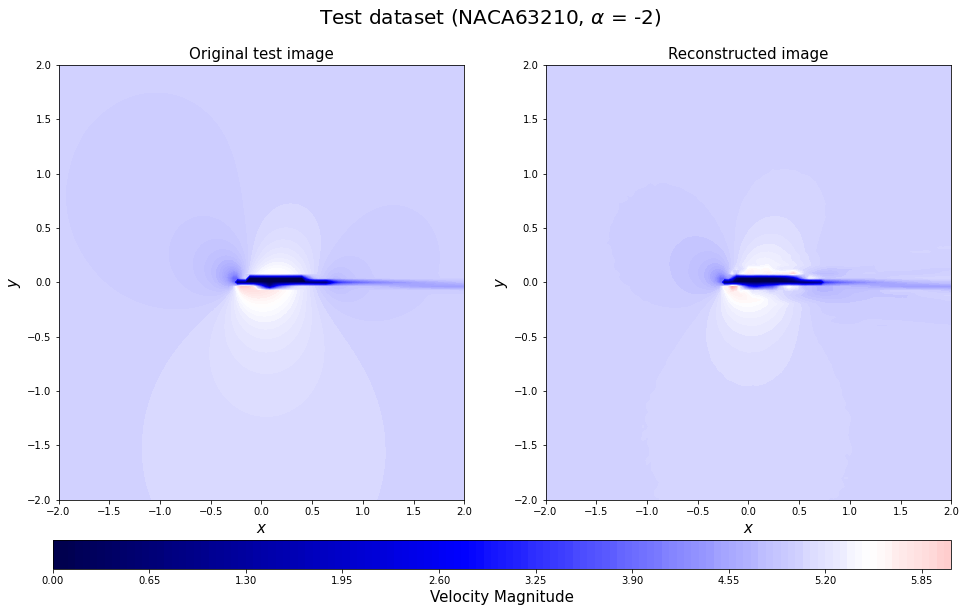

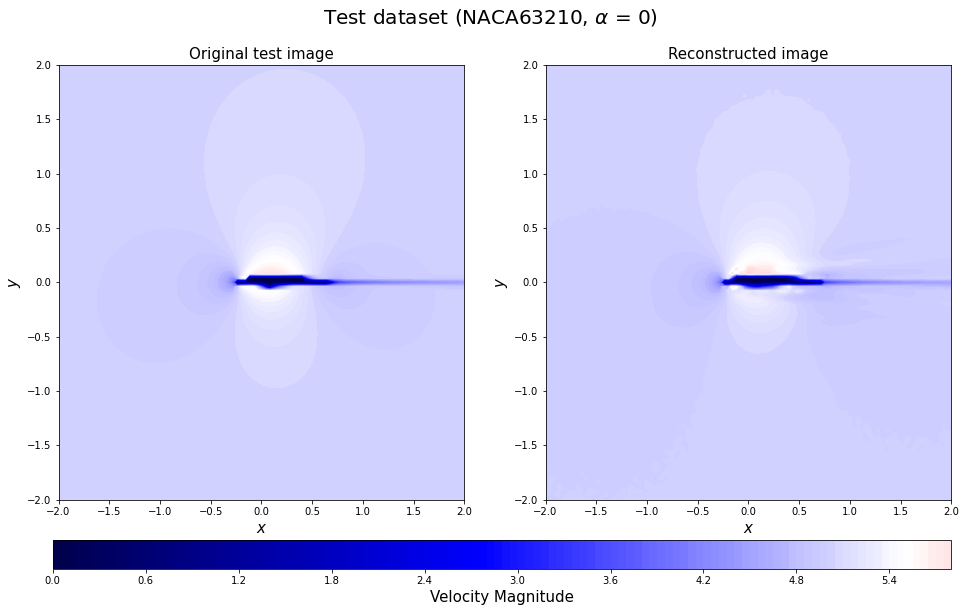

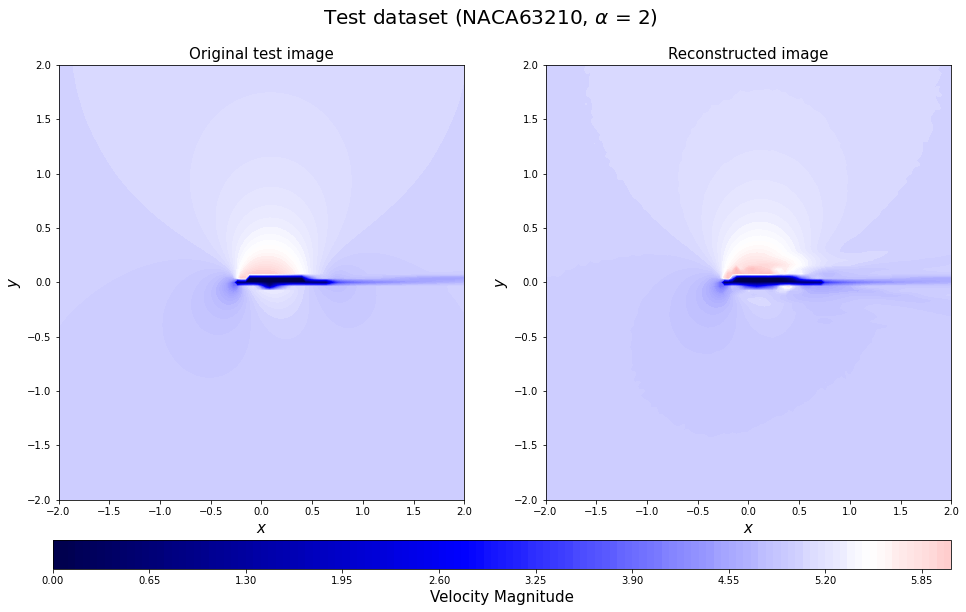

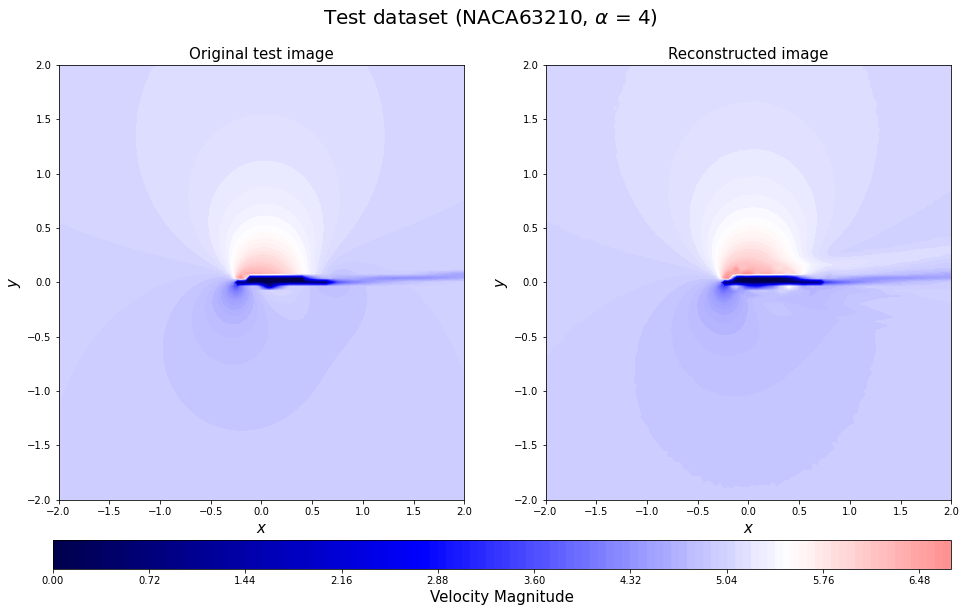

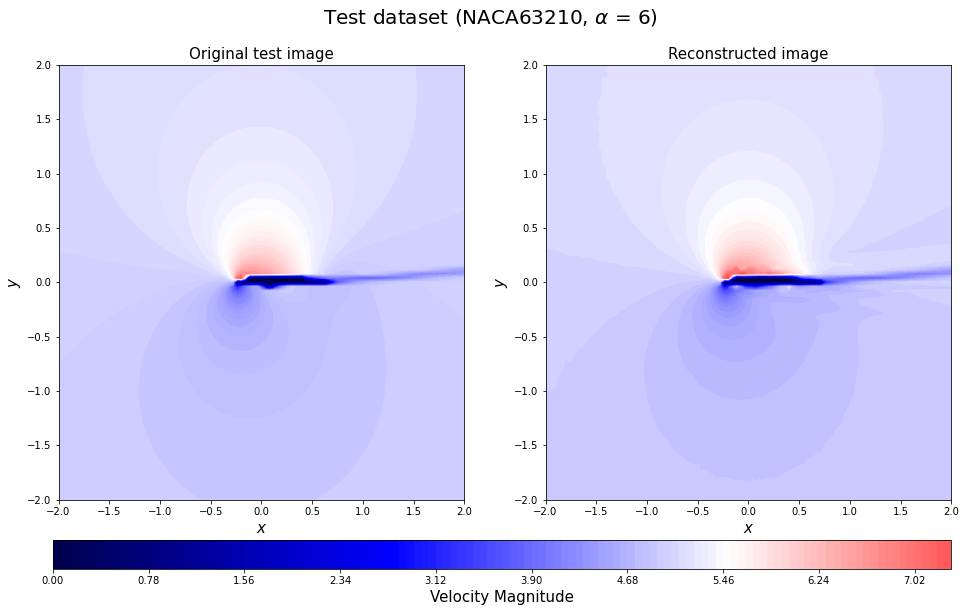

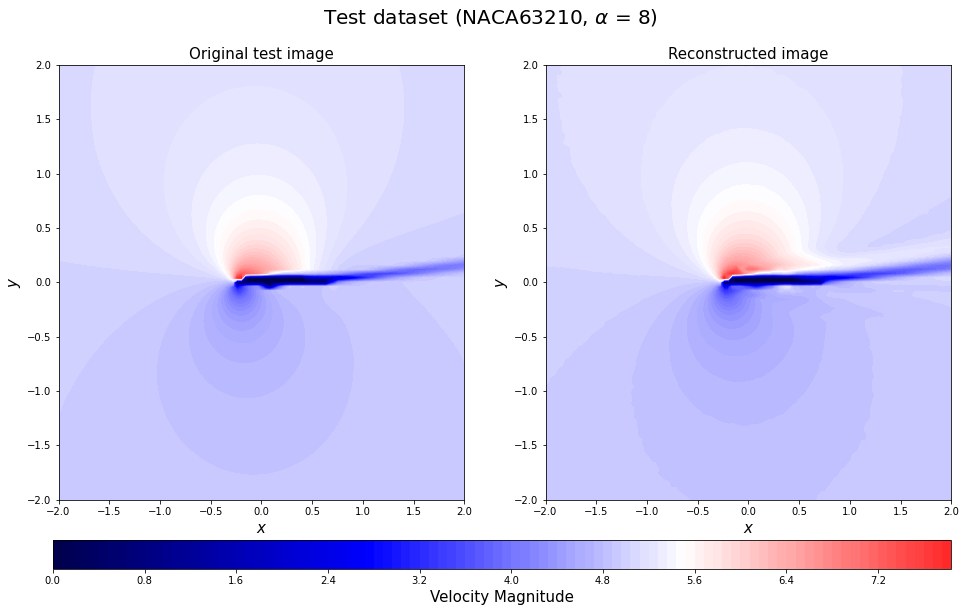

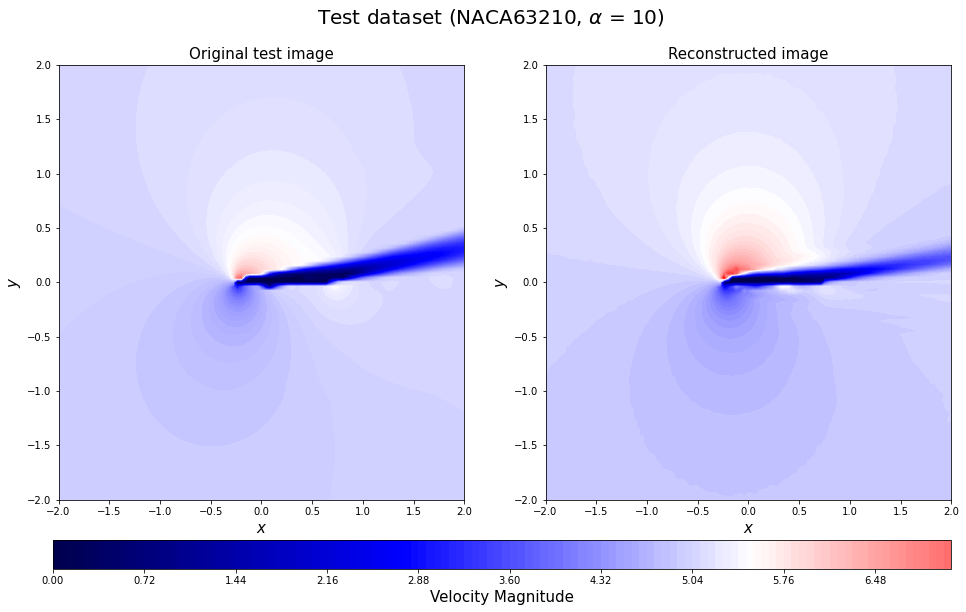

In [80]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_test2_rotate = y_test[2*11+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[2*11+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test2_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[2*11+c])[3:-2], aa_test[2*11+c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[2*11+c])[3:-2])+str(aa_test[2*11+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

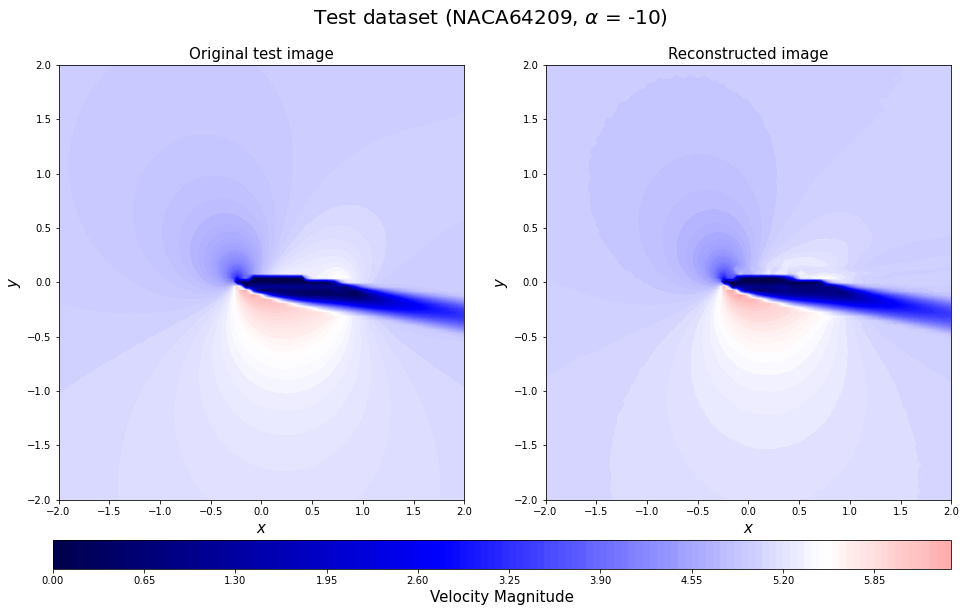

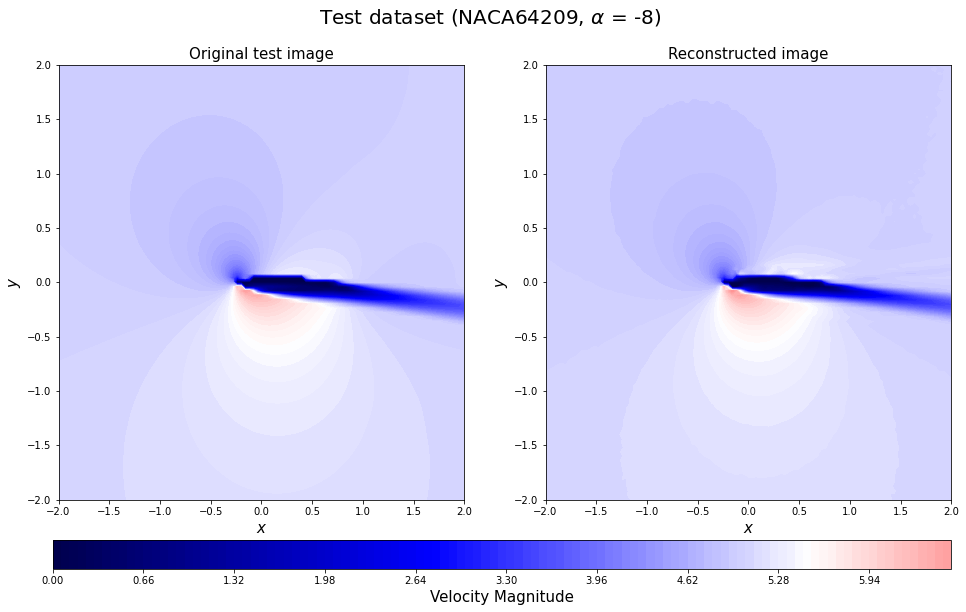

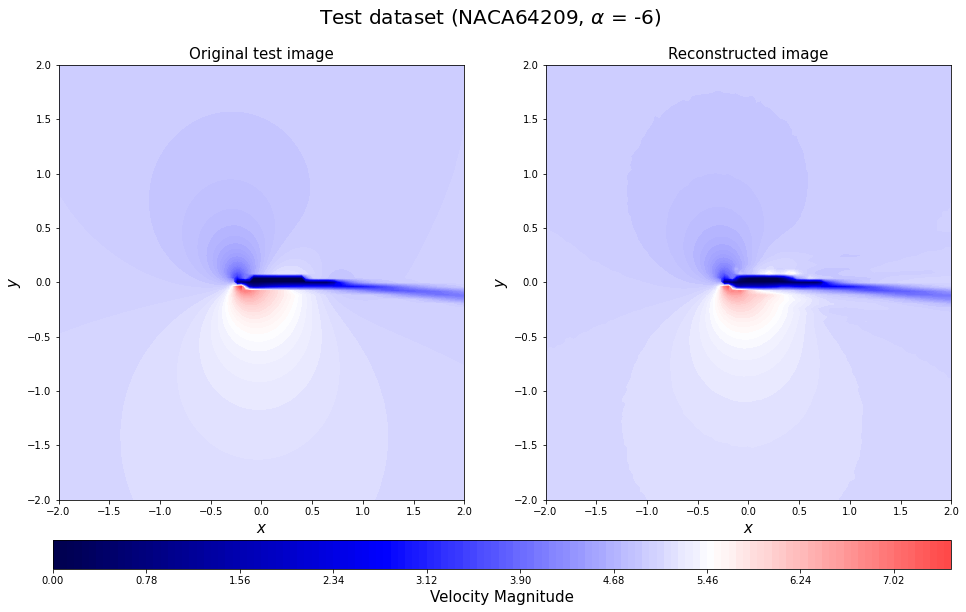

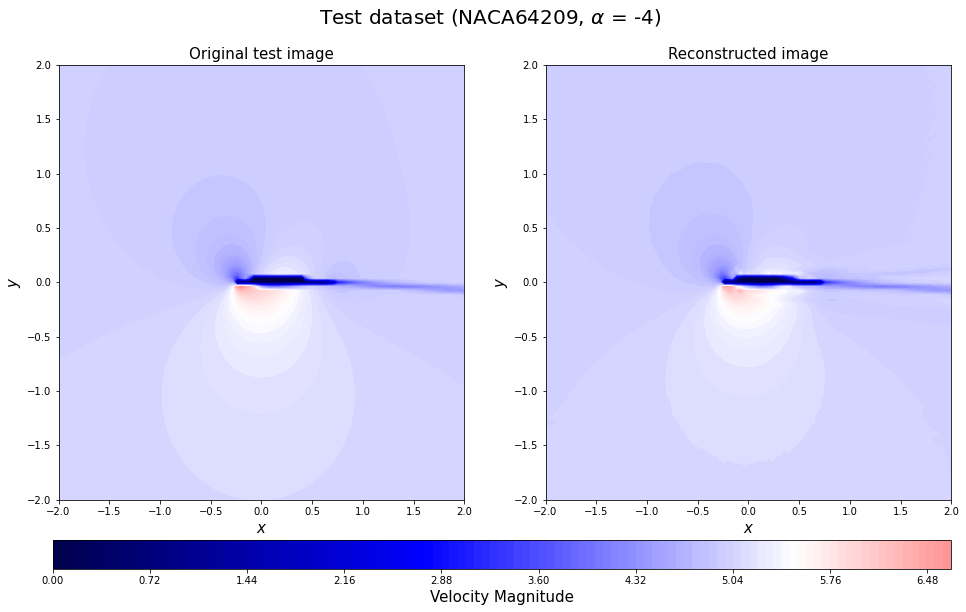

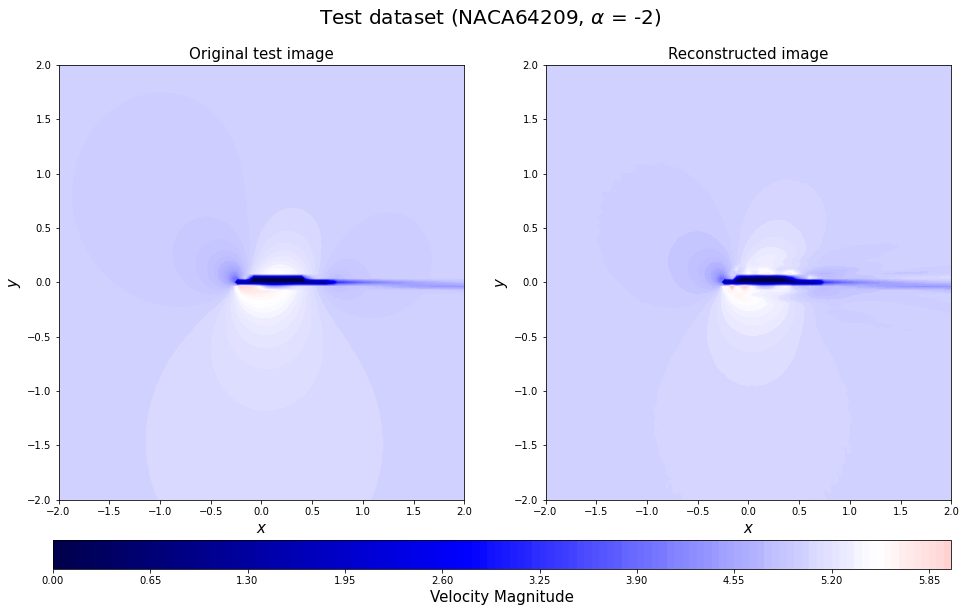

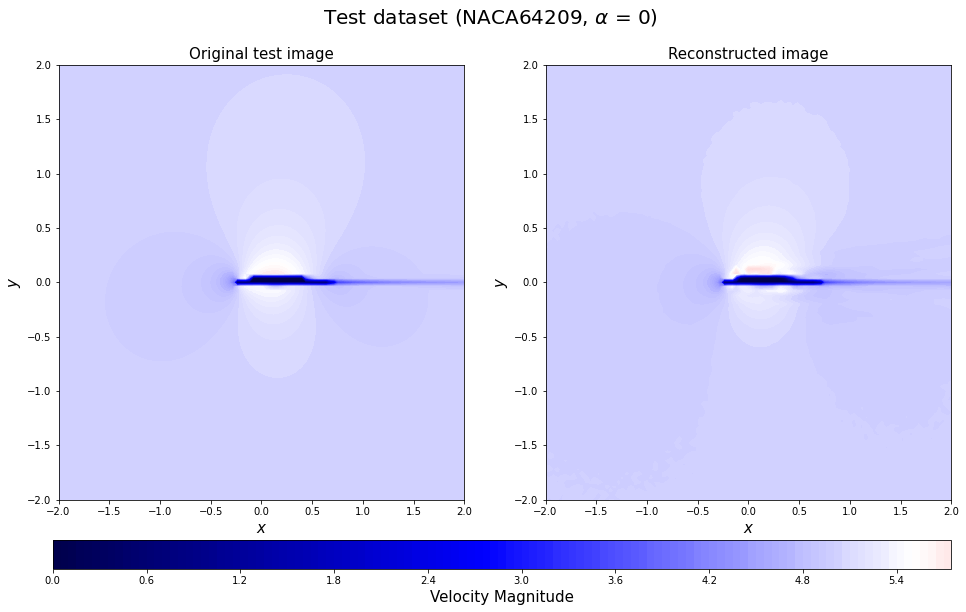

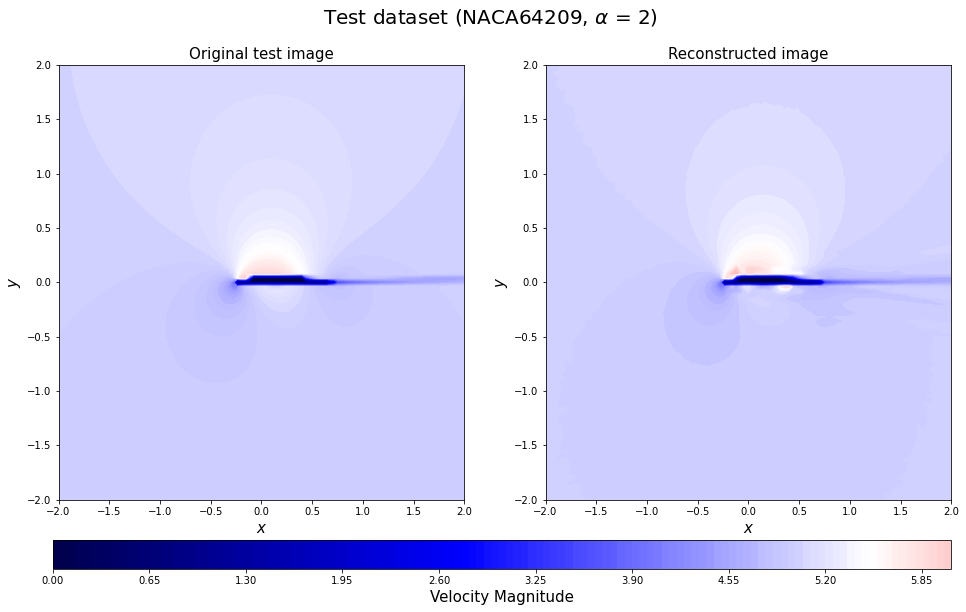

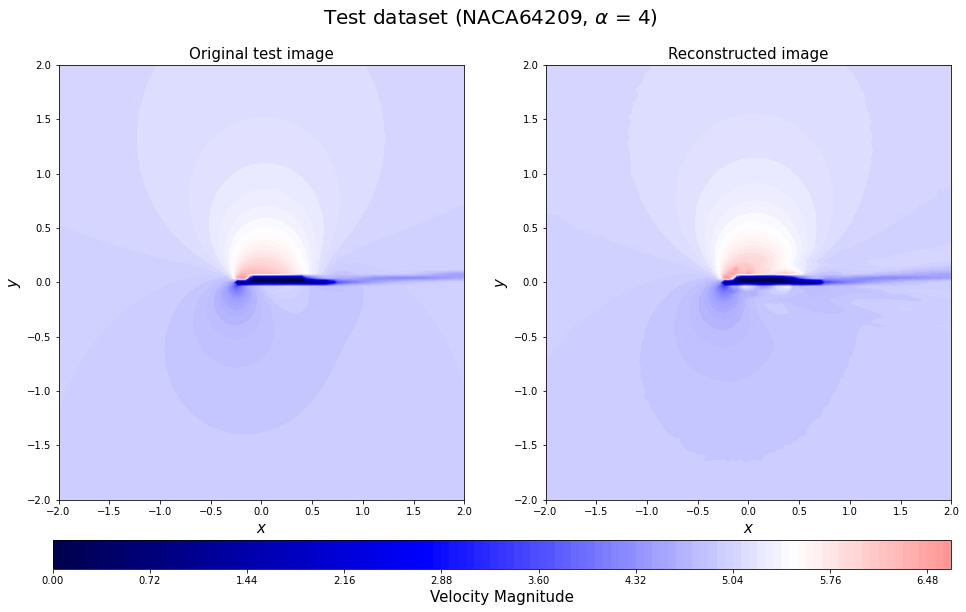

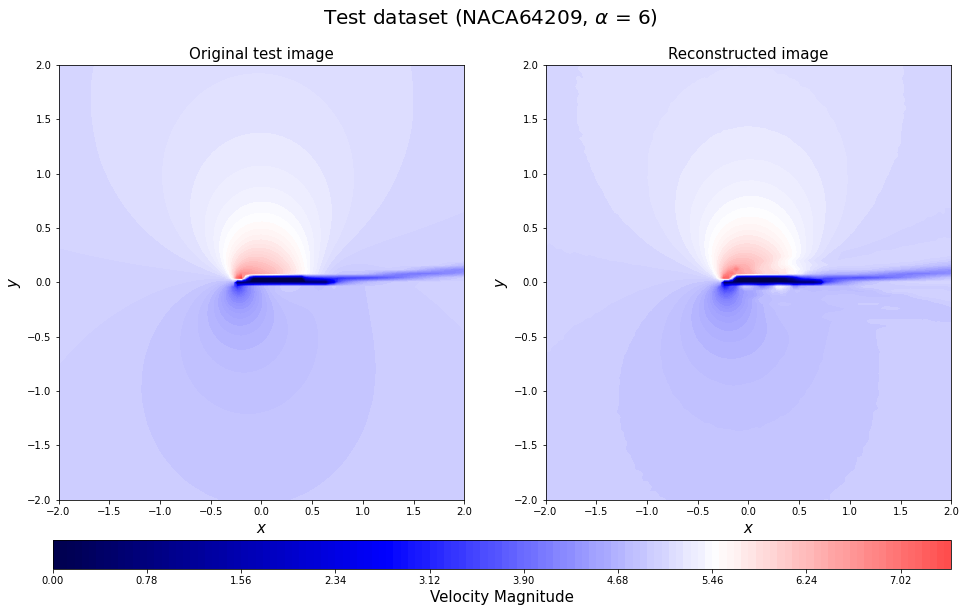

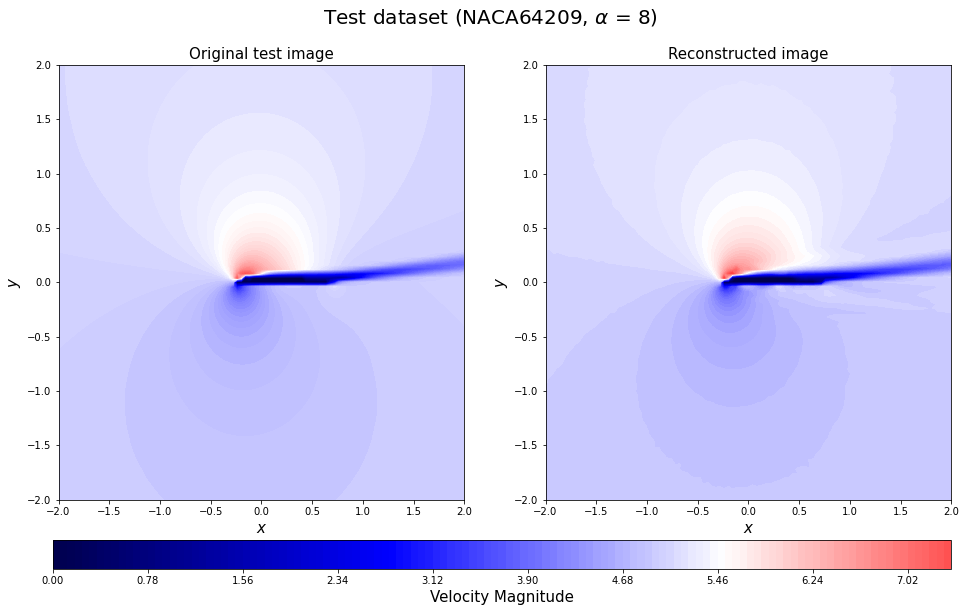

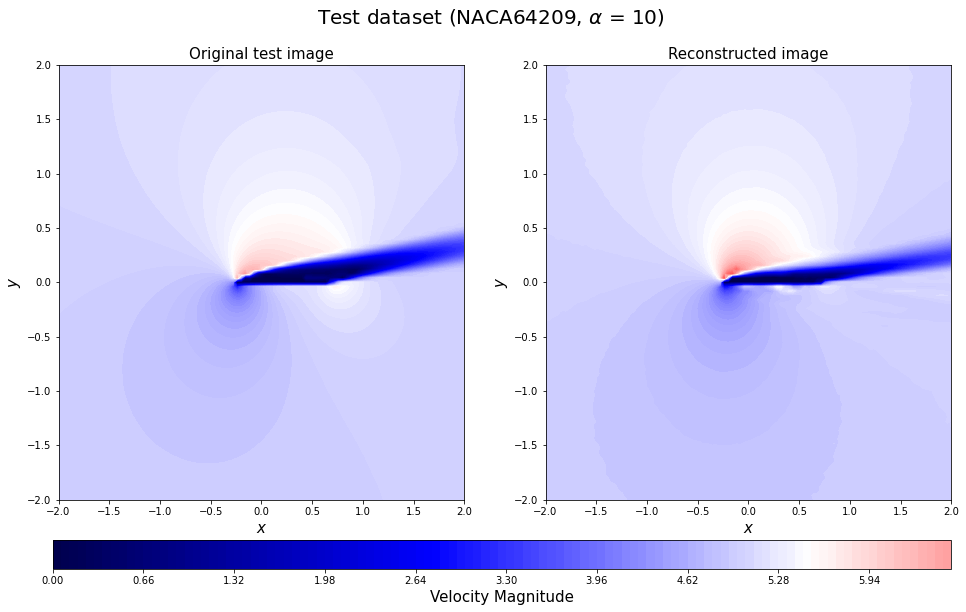

In [81]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_test0_rotate = y_test[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

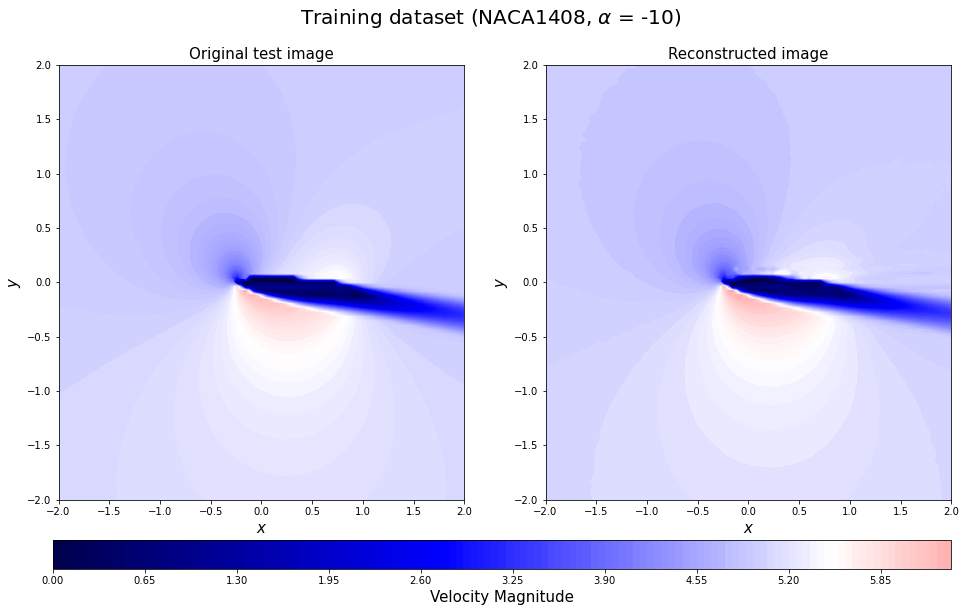

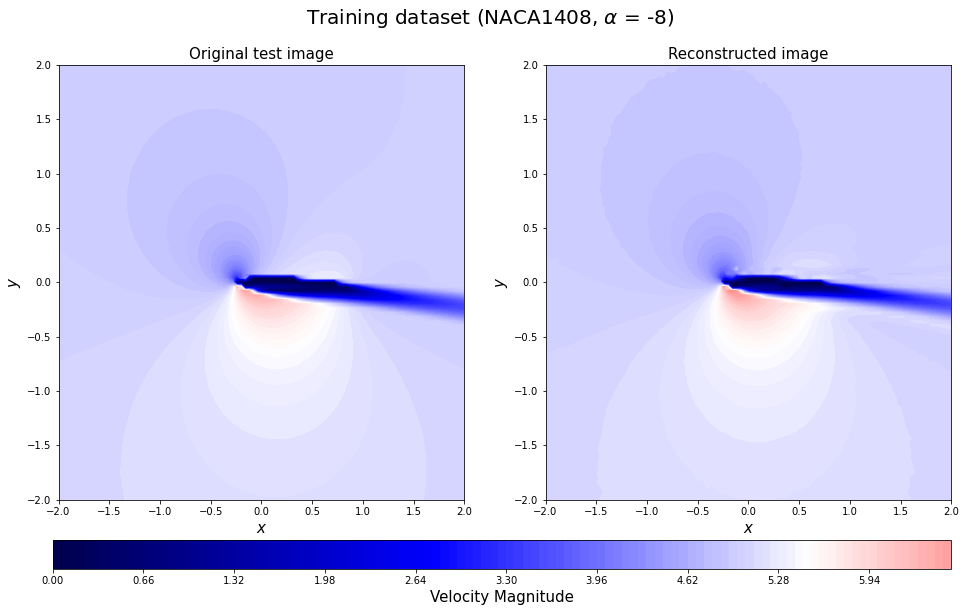

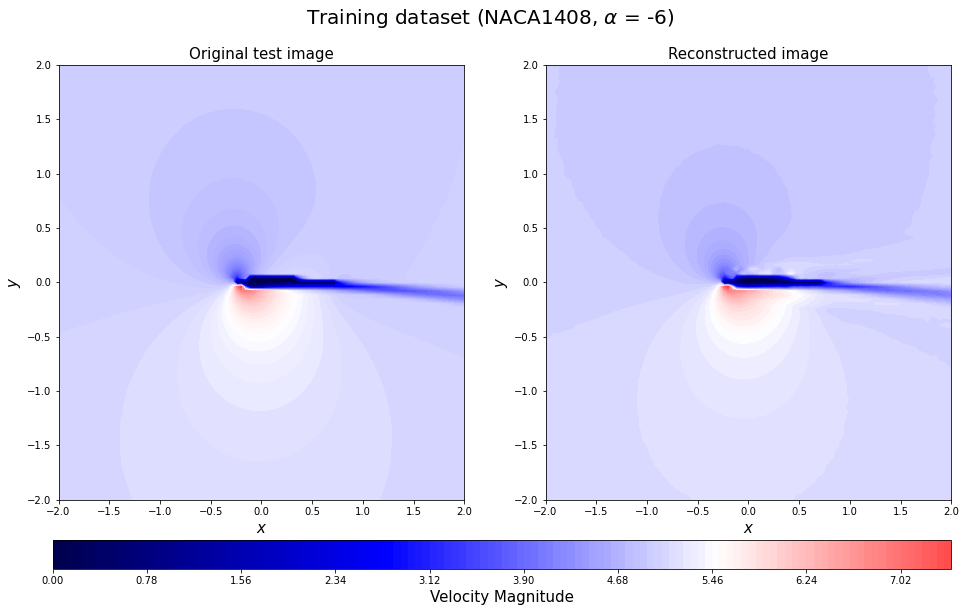

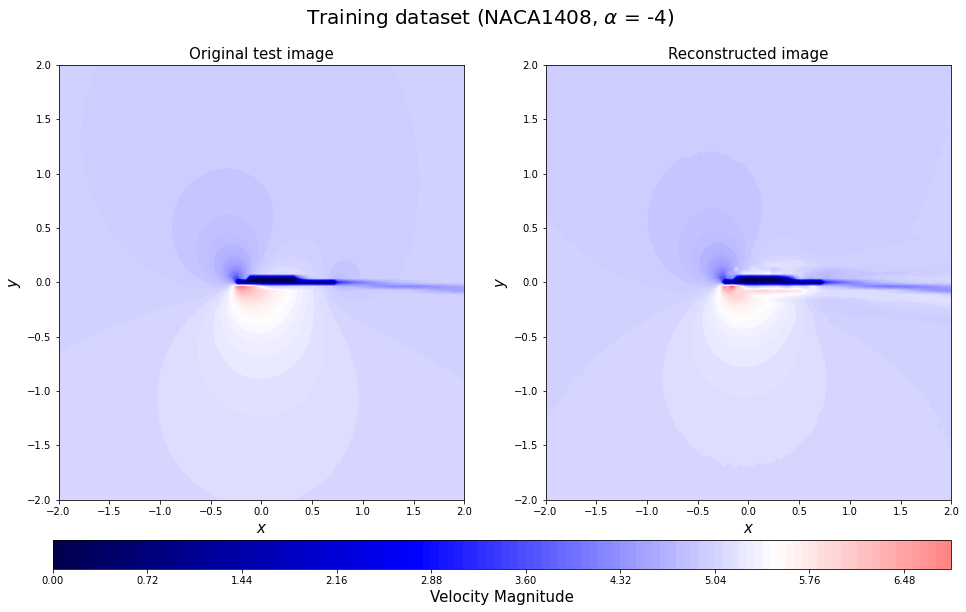

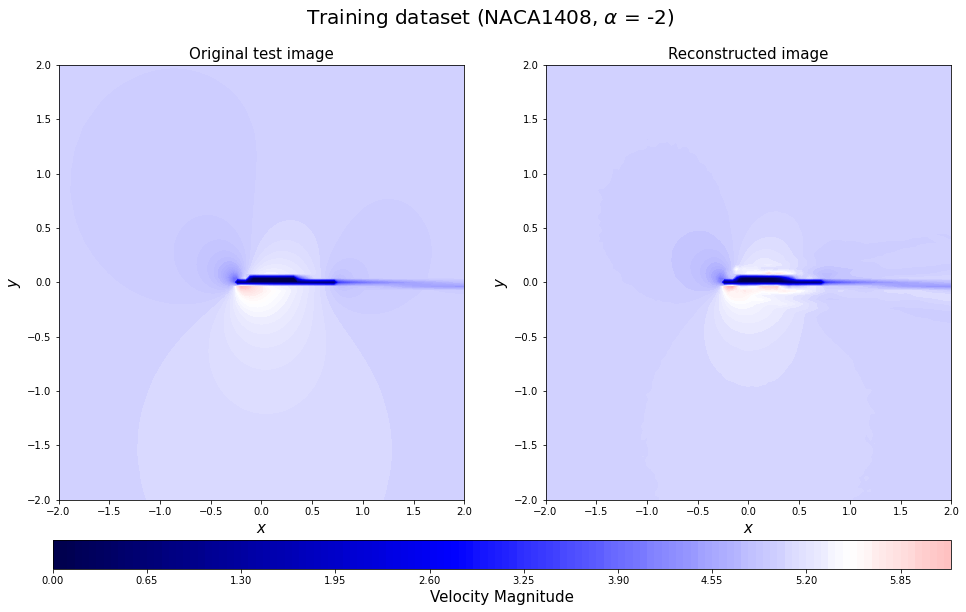

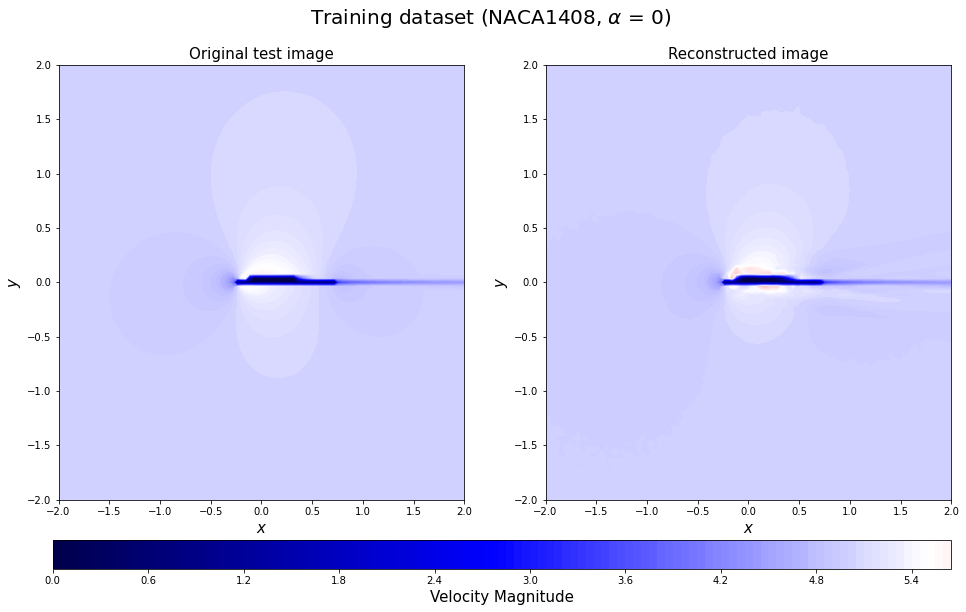

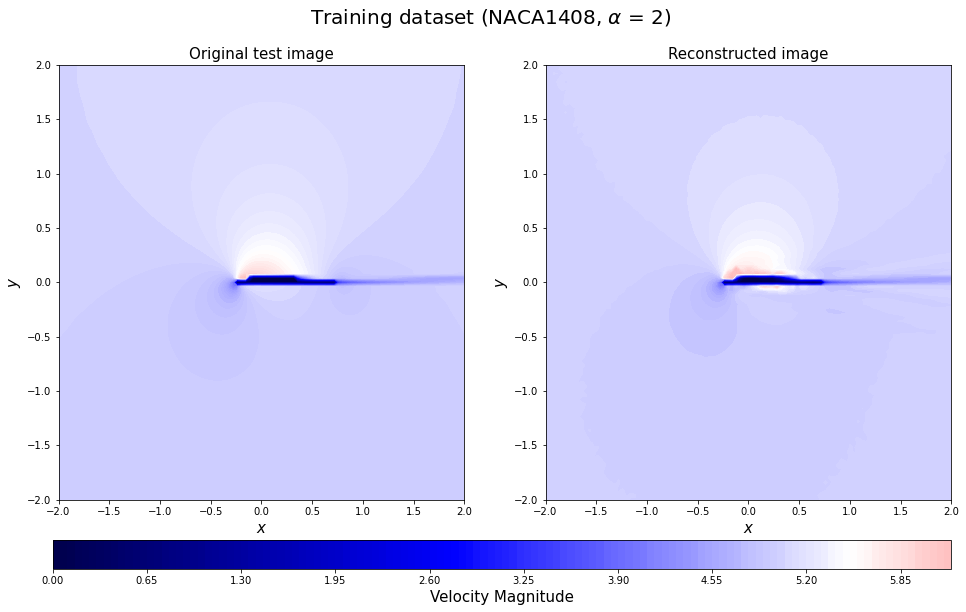

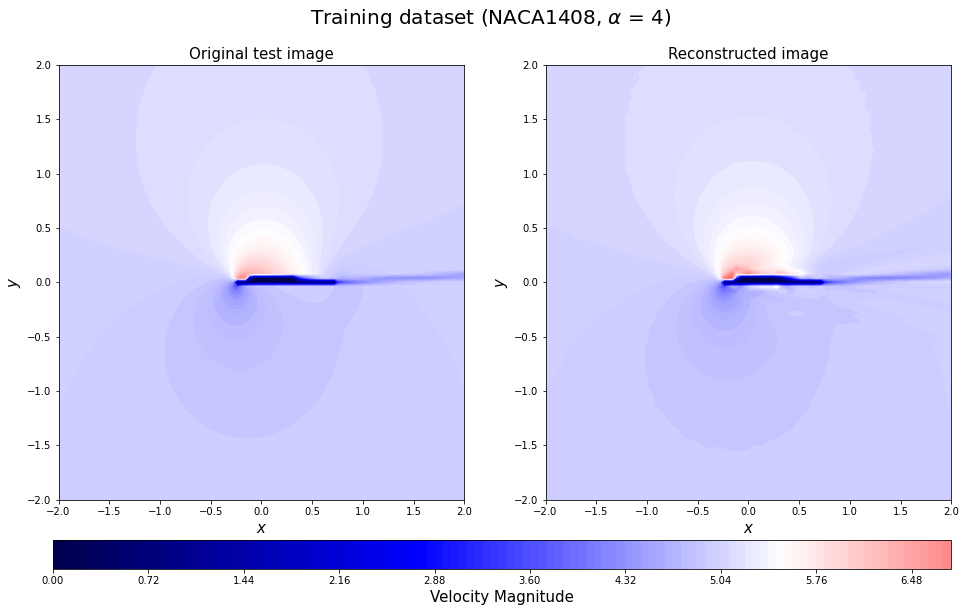

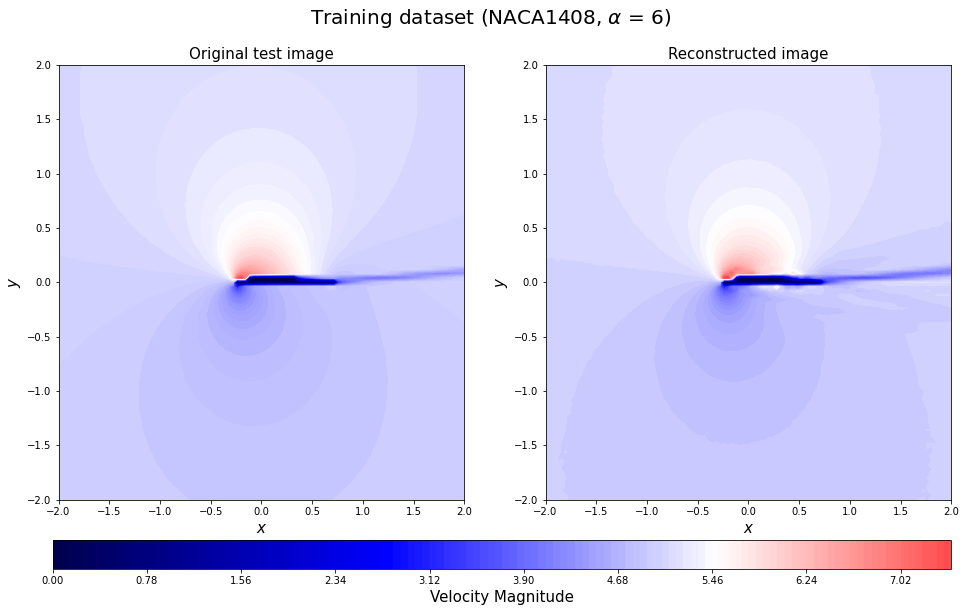

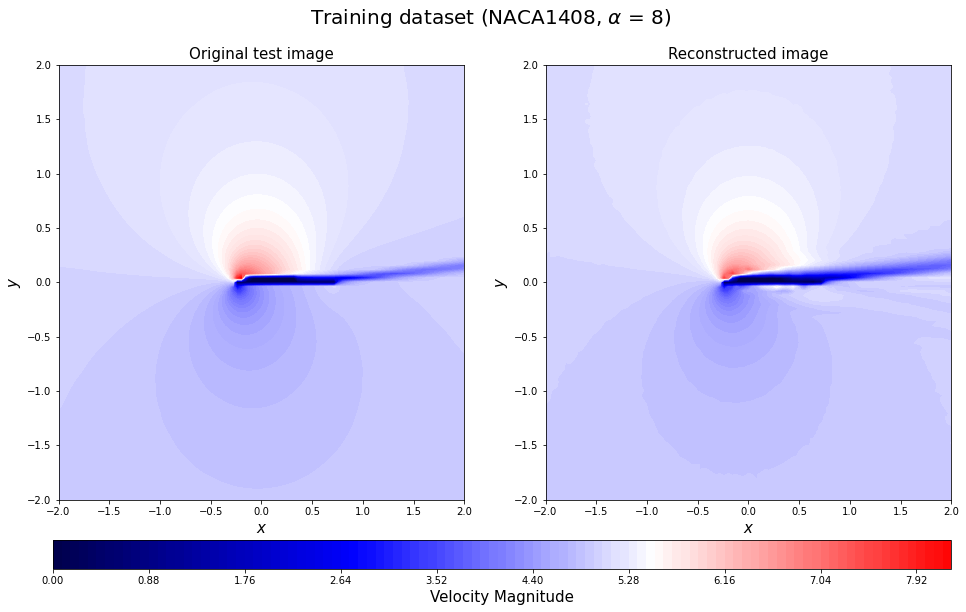

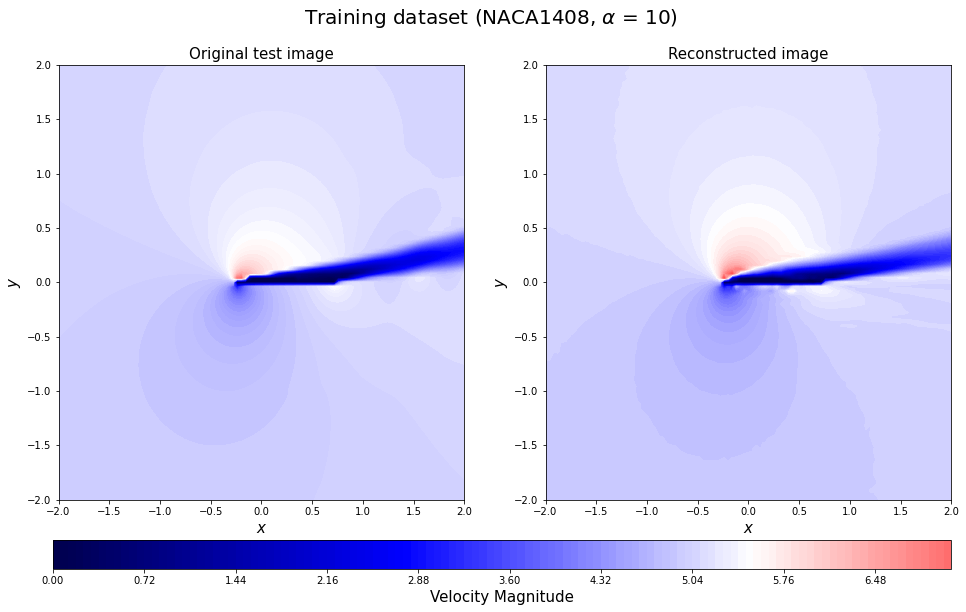

In [82]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_train0_rotate = y_train[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[c])[3:-2], aa_train[c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[c])[3:-2])+str(aa_train[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

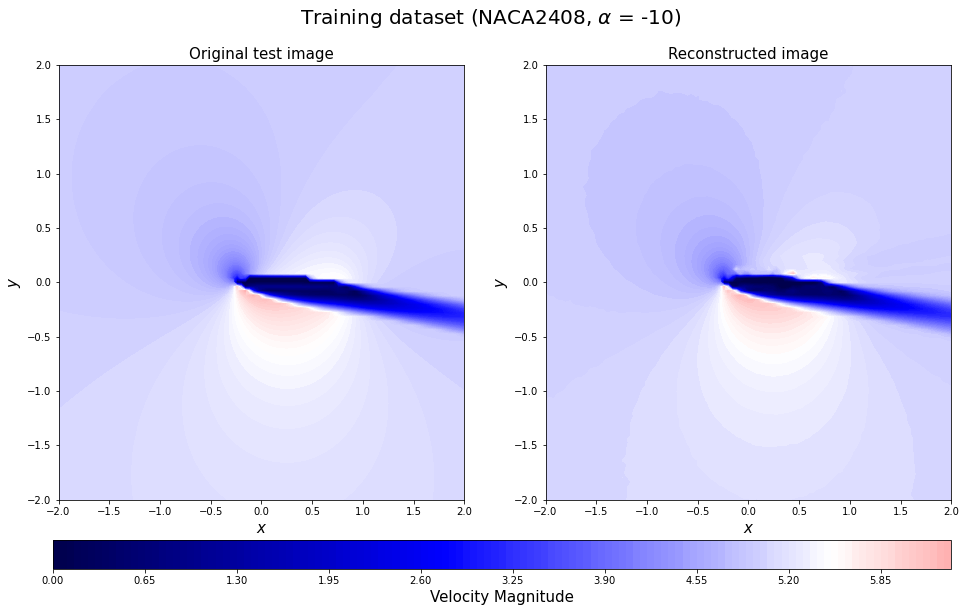

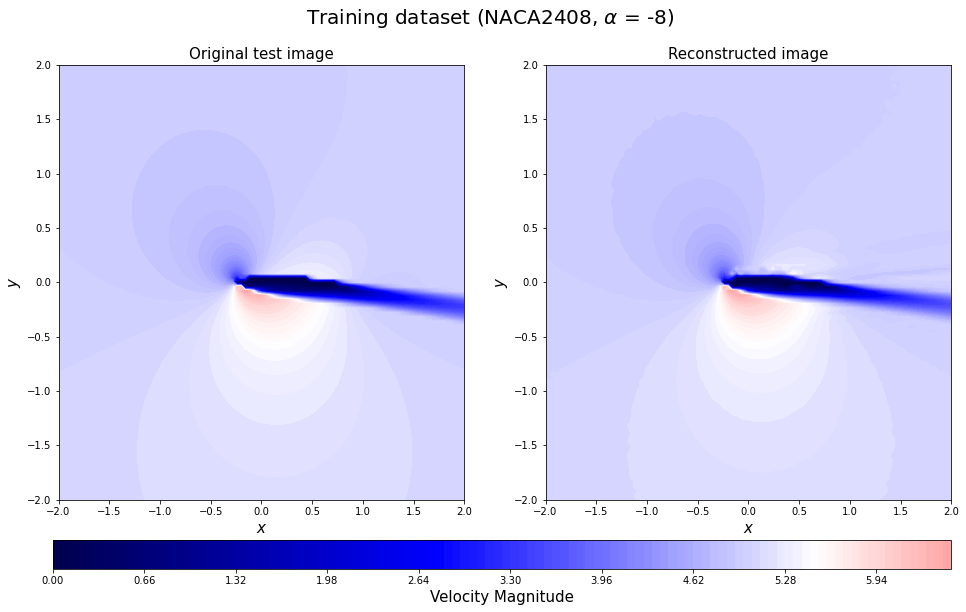

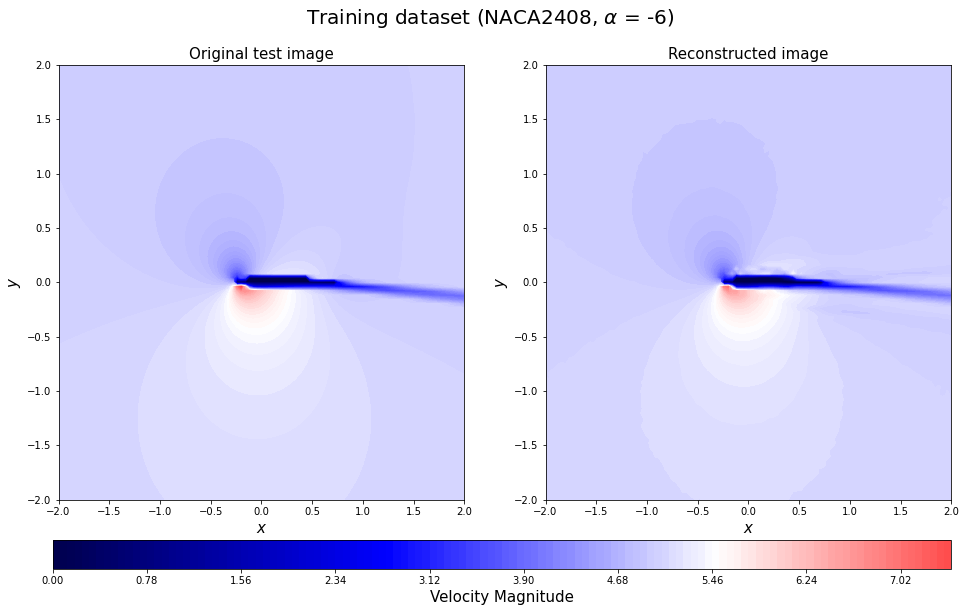

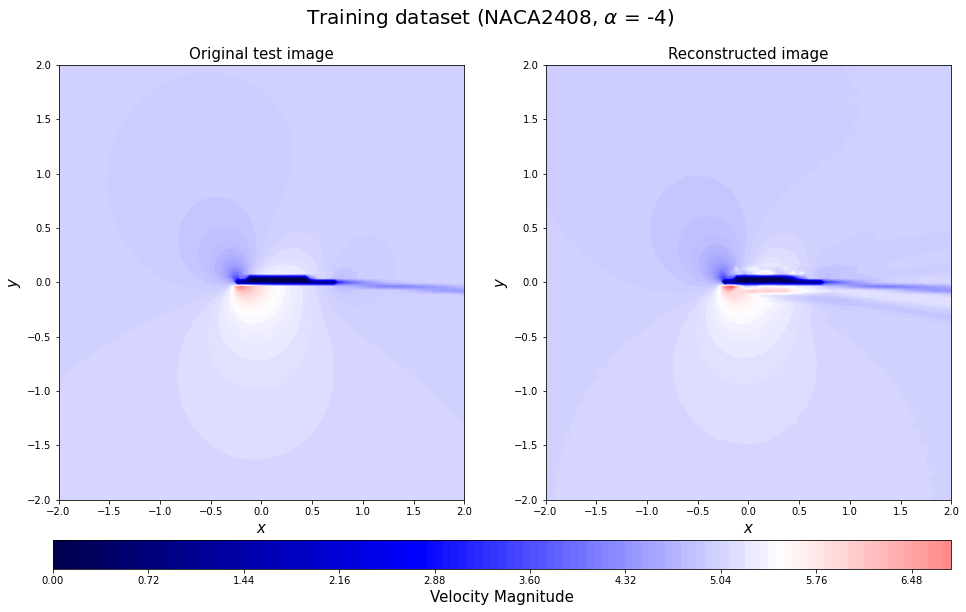

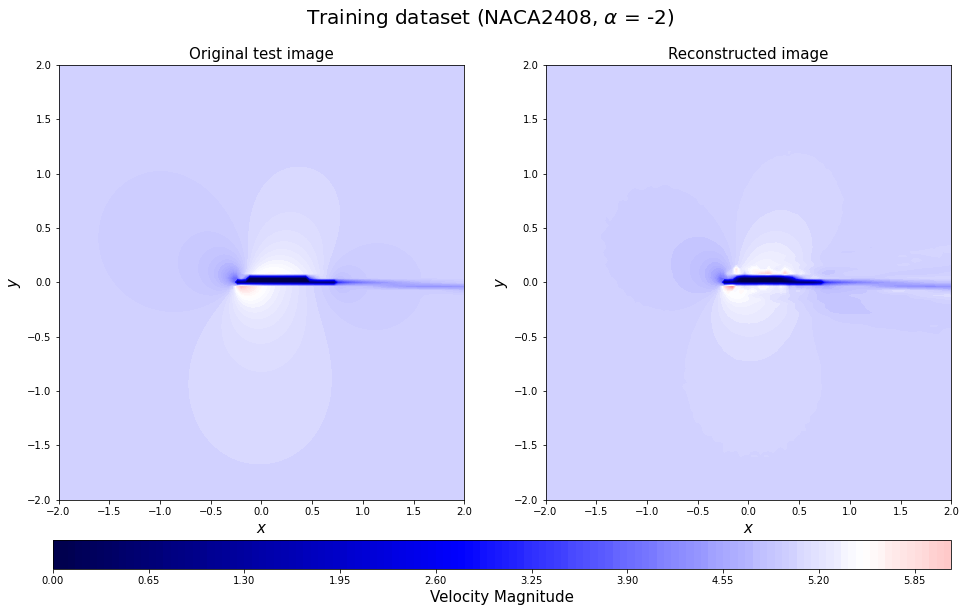

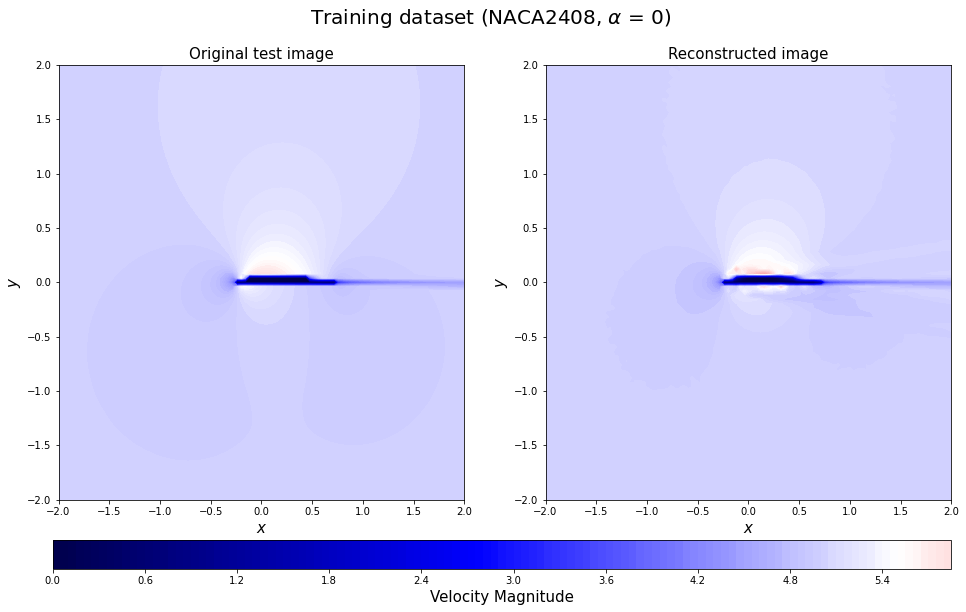

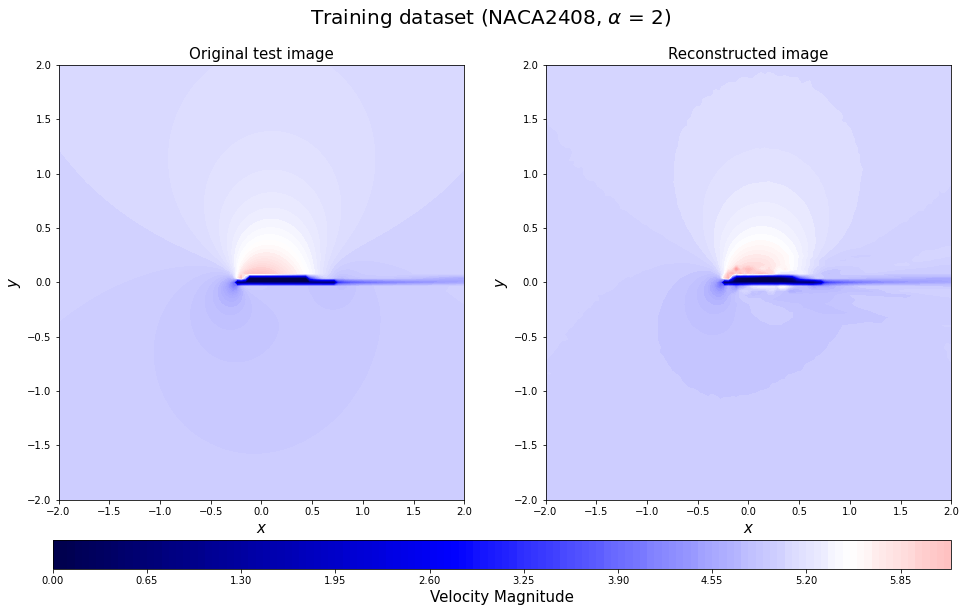

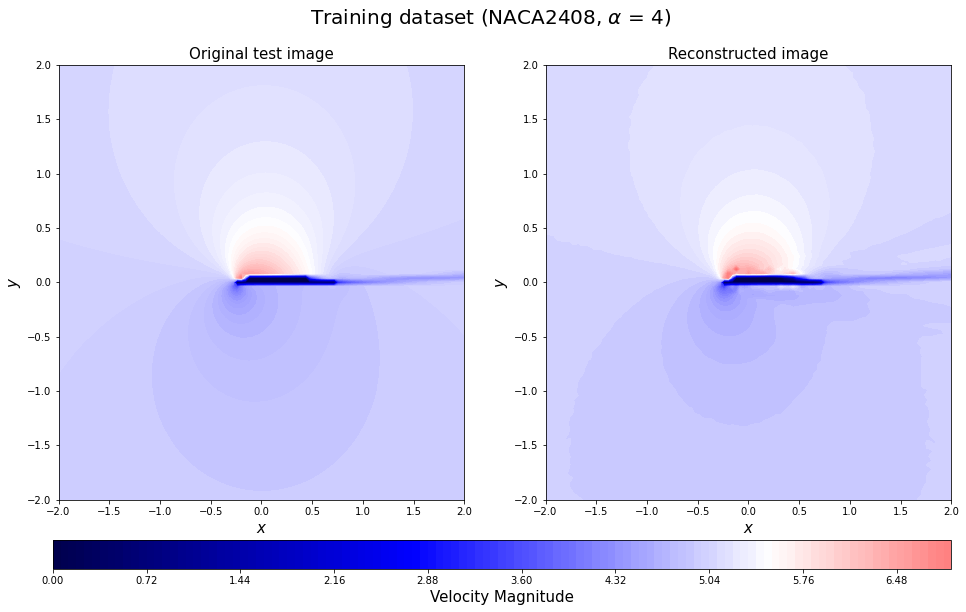

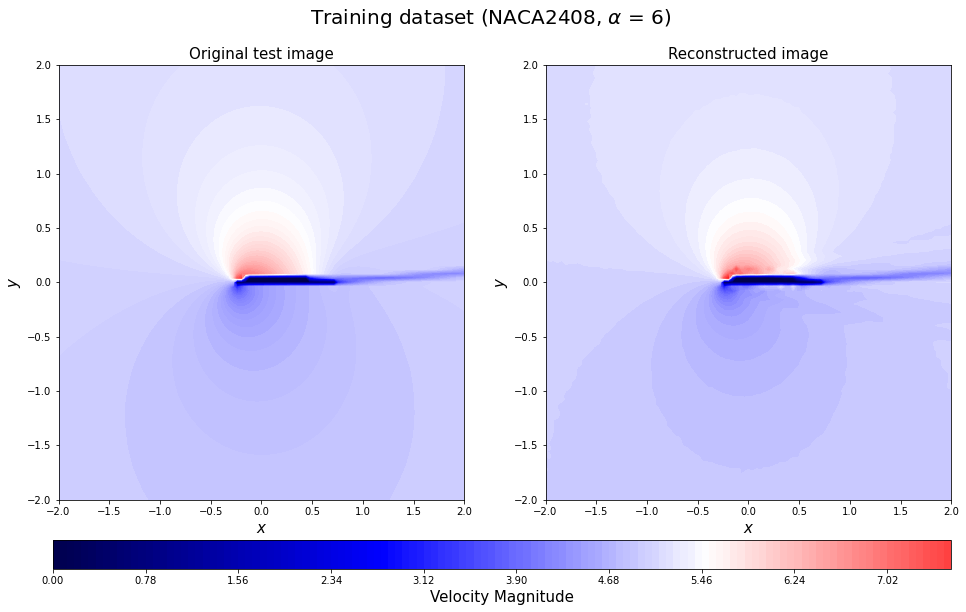

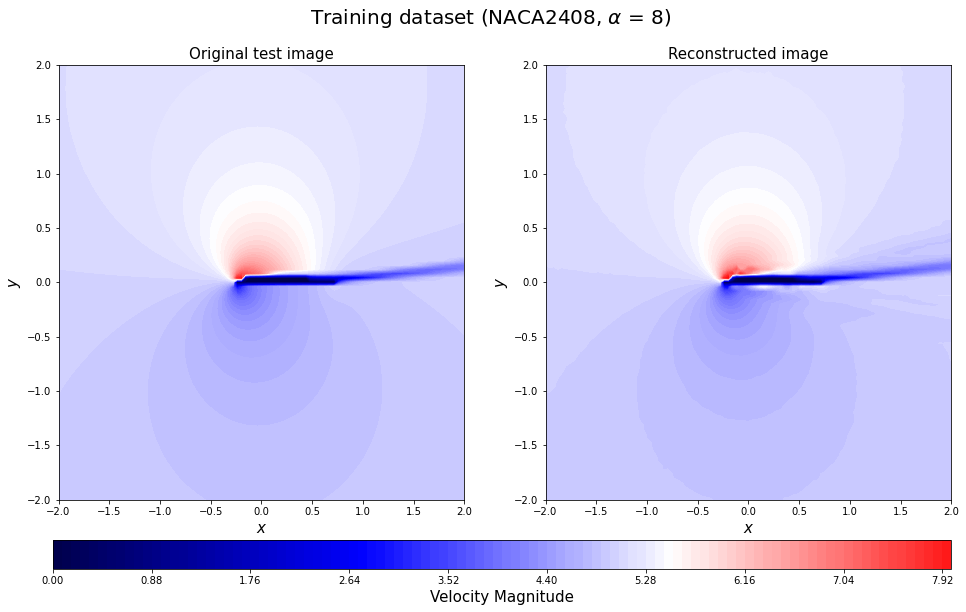

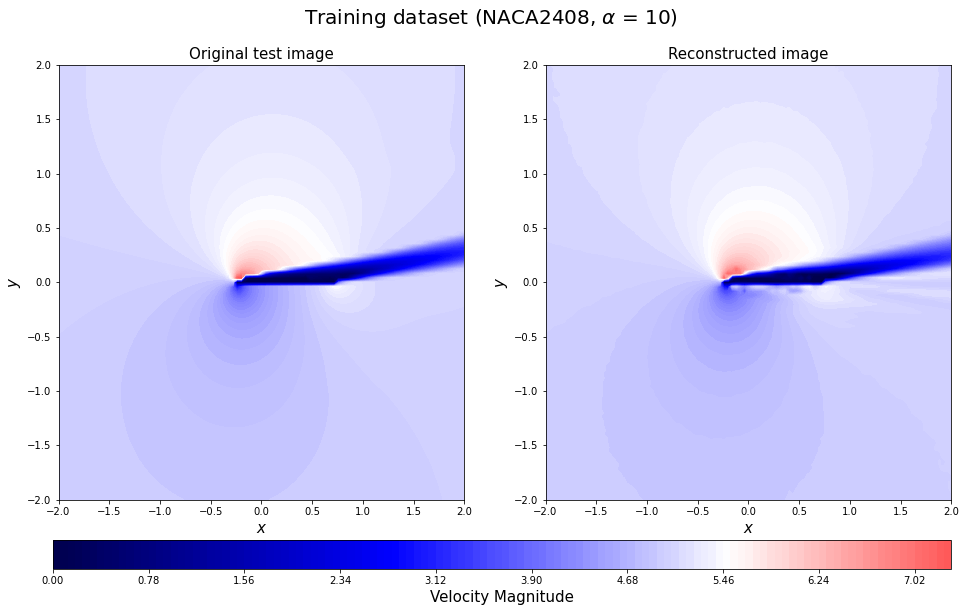

In [83]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_train20_rotate = y_train[20*11+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[20*11+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train20_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[20*11+c])[3:-2], aa_train[20*11+c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[20*11+c])[3:-2])+str(aa_train[20*11+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

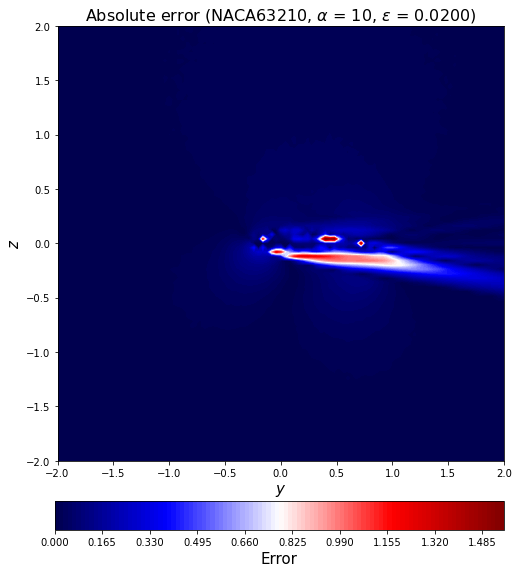

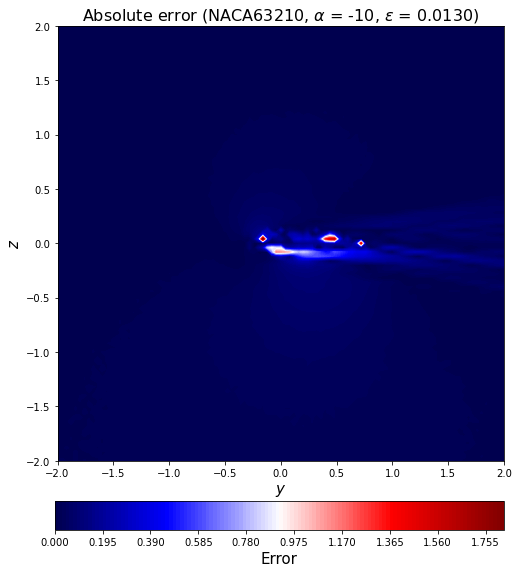

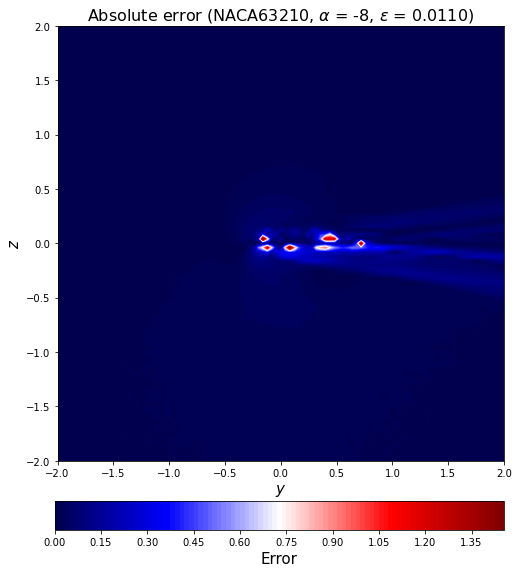

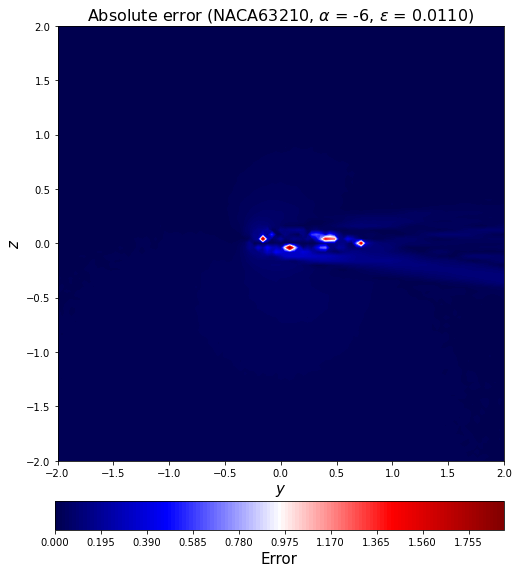

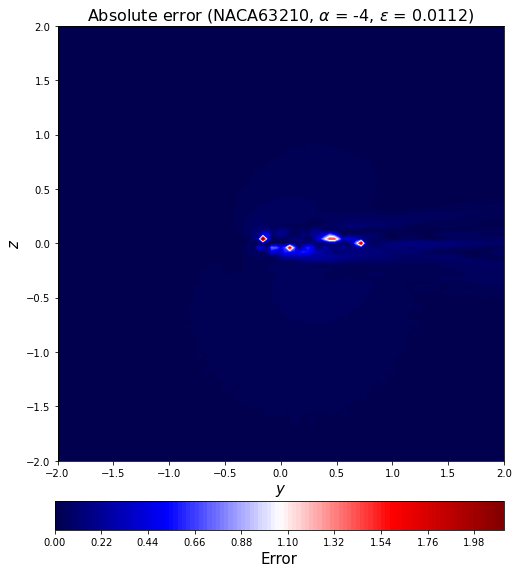

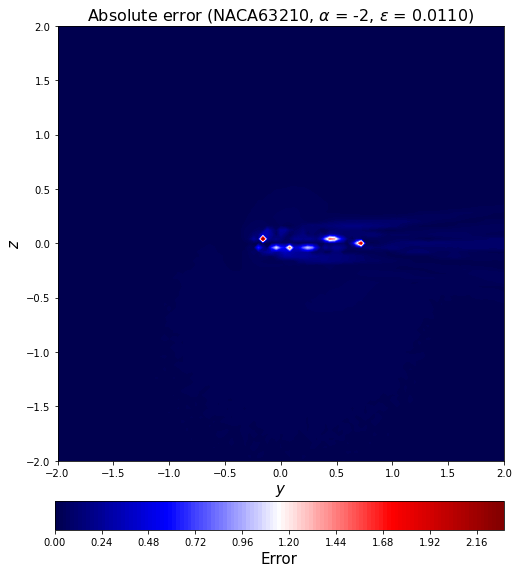

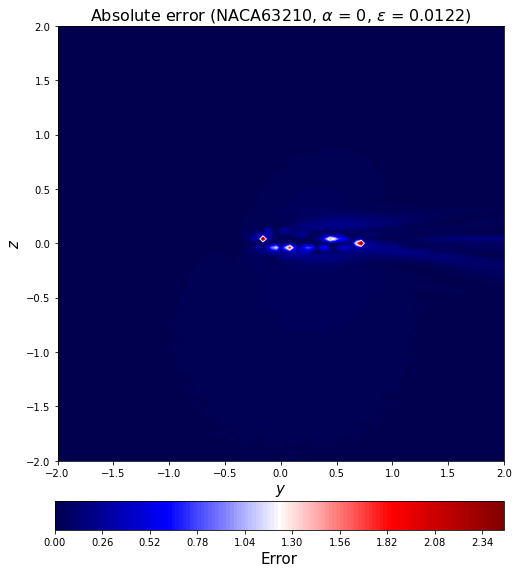

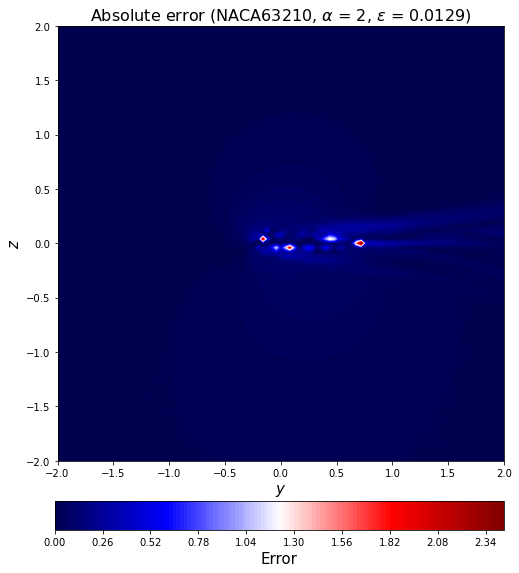

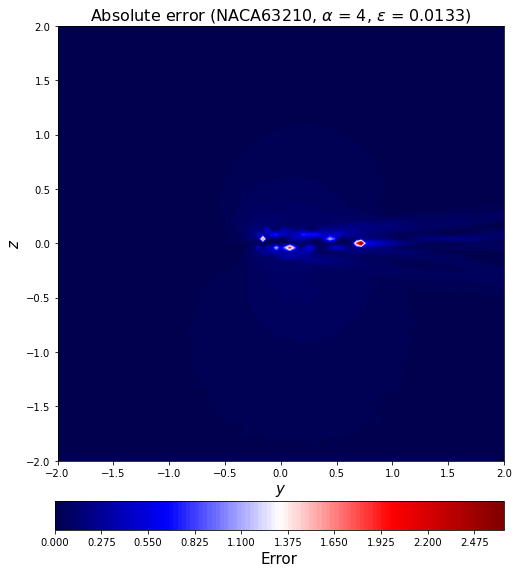

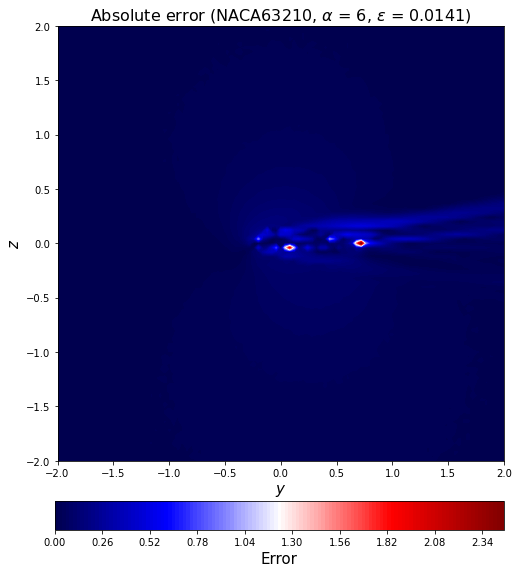

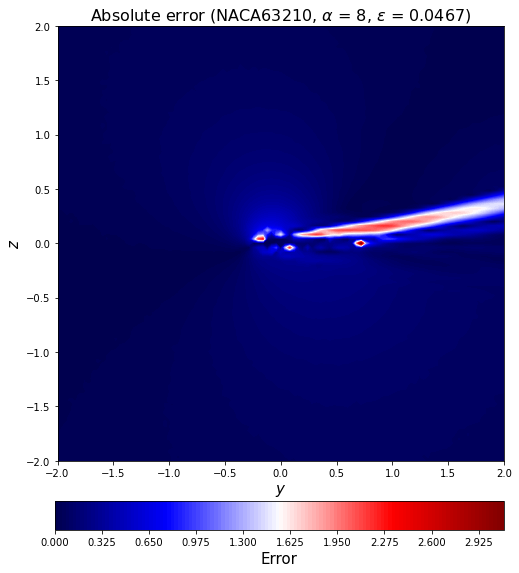

In [85]:
for c in range(0,11):
    error_test_abs2_rotate = error_test_abs[2*11+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[2*11+c])[3:-2],
                                                                       aa_test[2*16+c], l2_error_test_list[2*11+c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[2*11+c])[3:-2])+str(aa_test[2*11+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

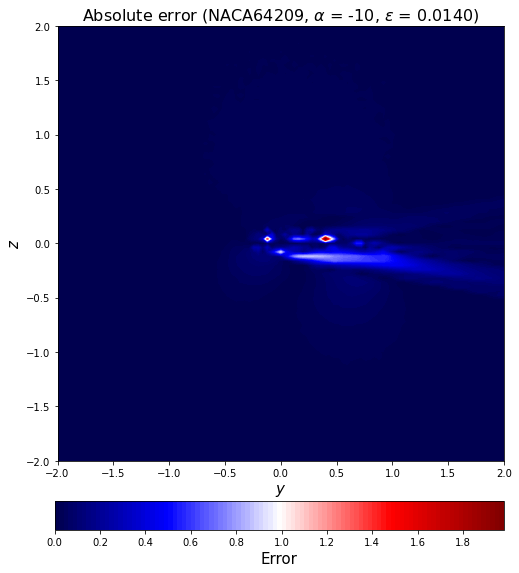

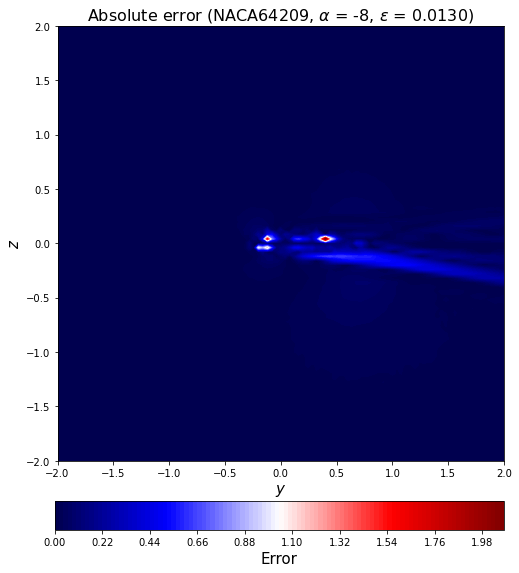

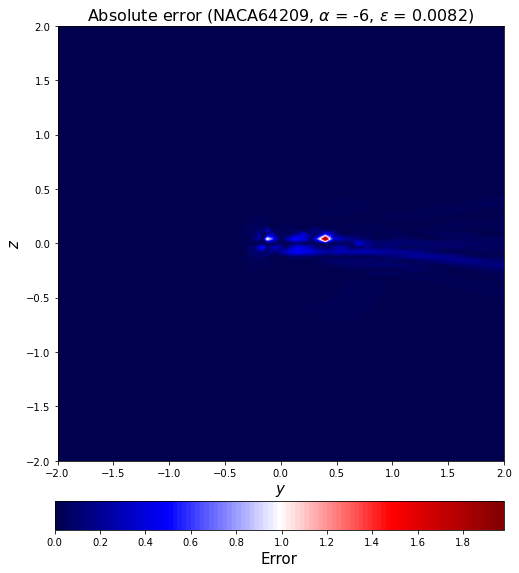

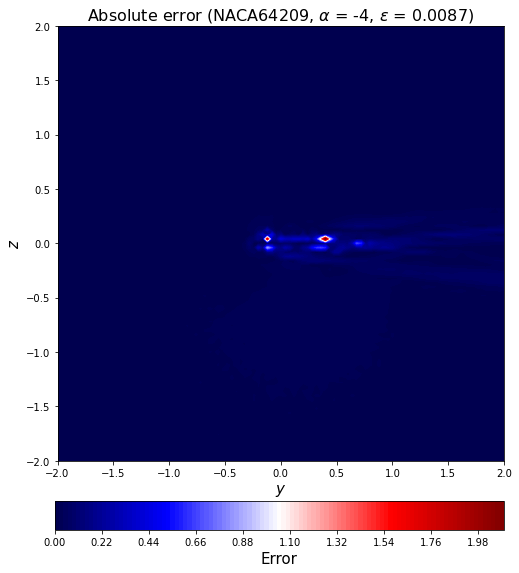

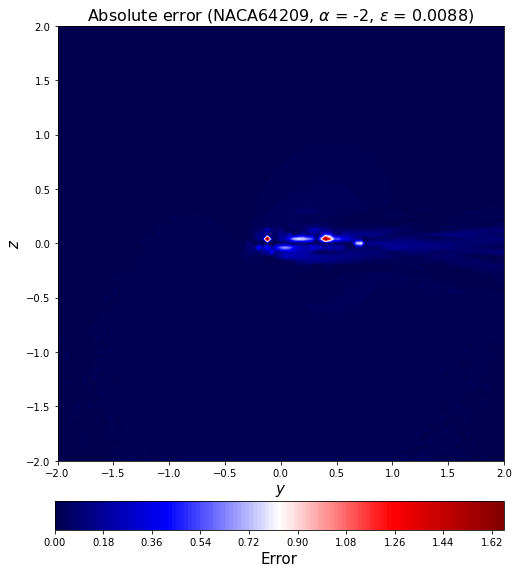

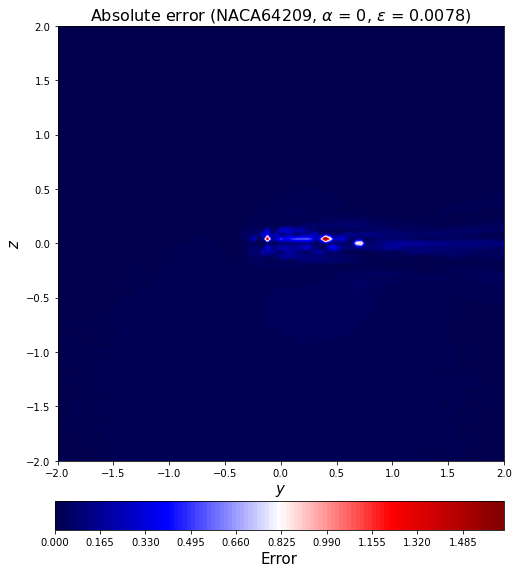

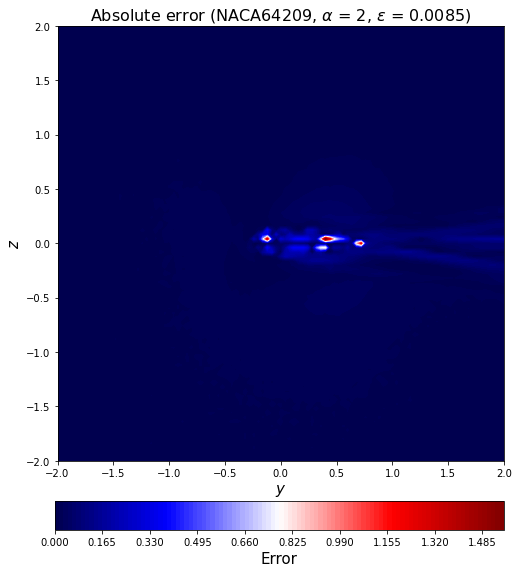

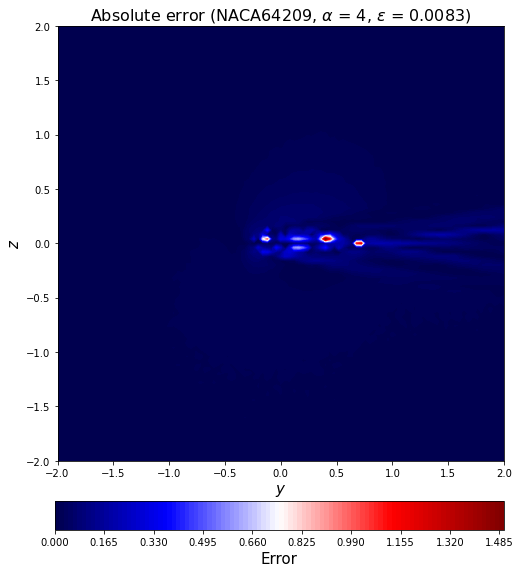

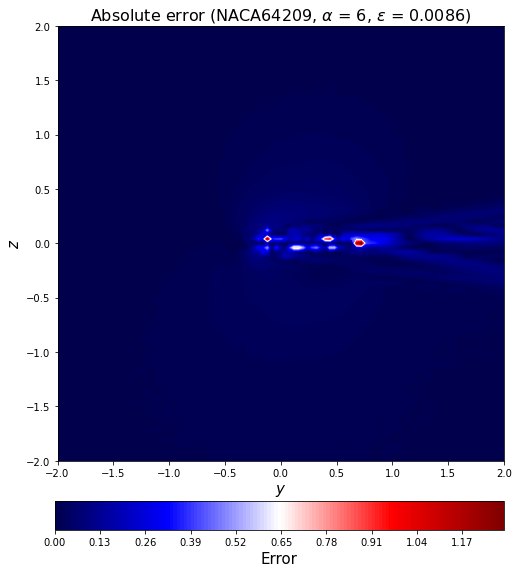

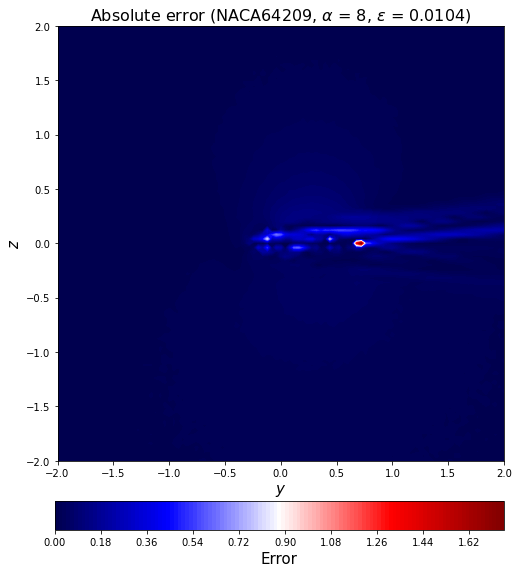

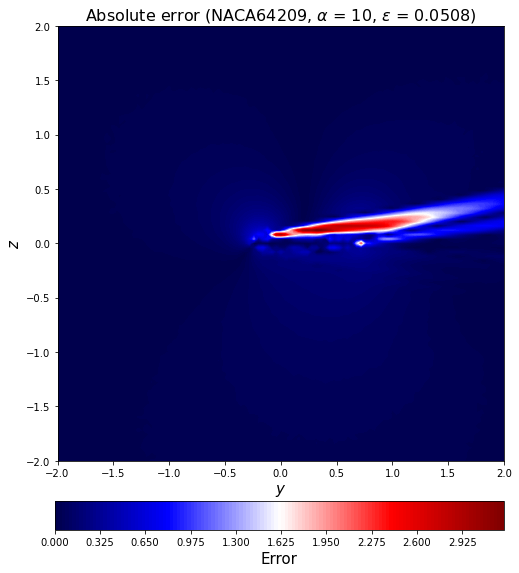

In [86]:
for c in range(0,11):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

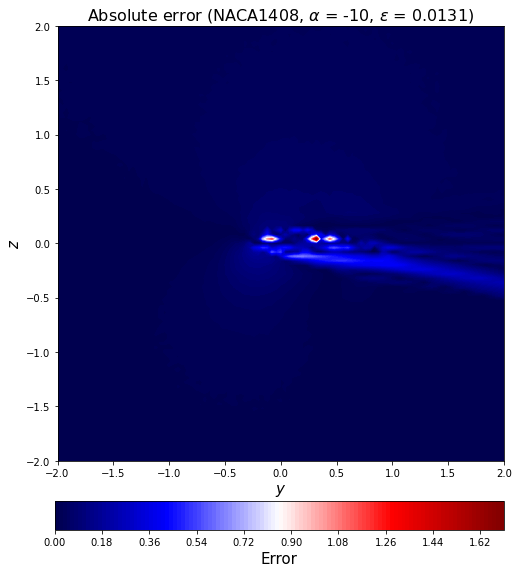

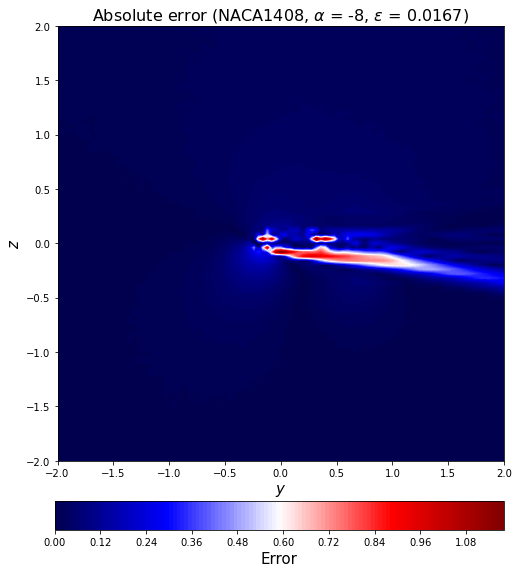

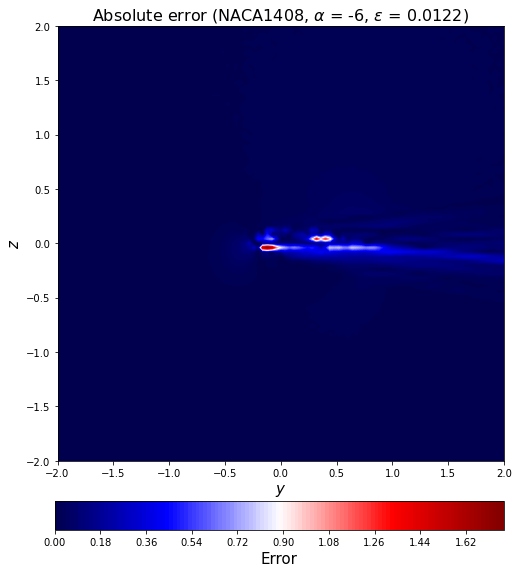

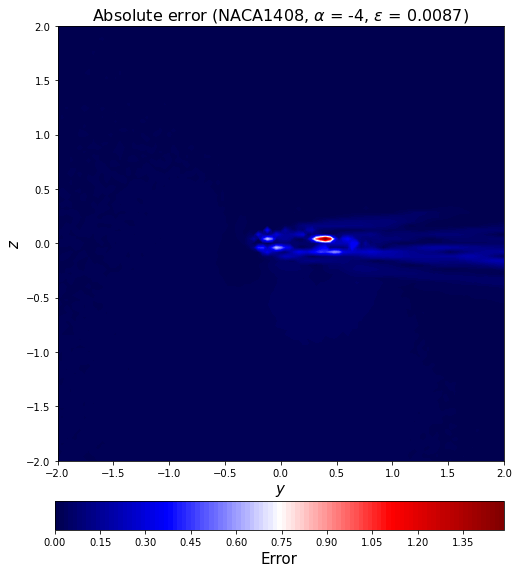

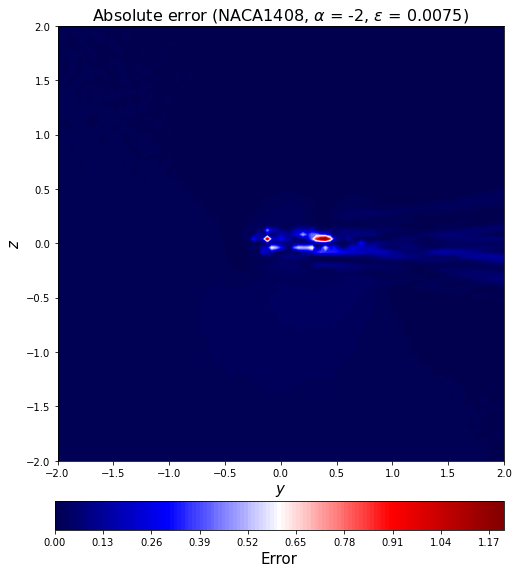

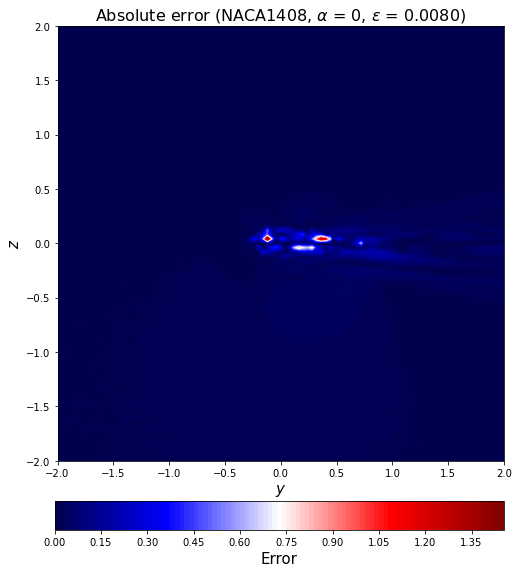

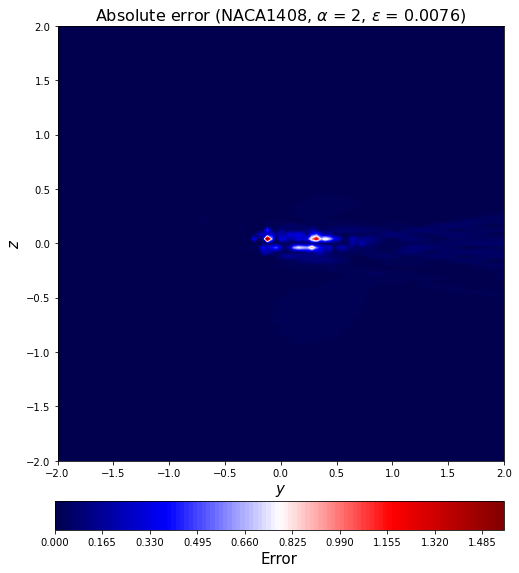

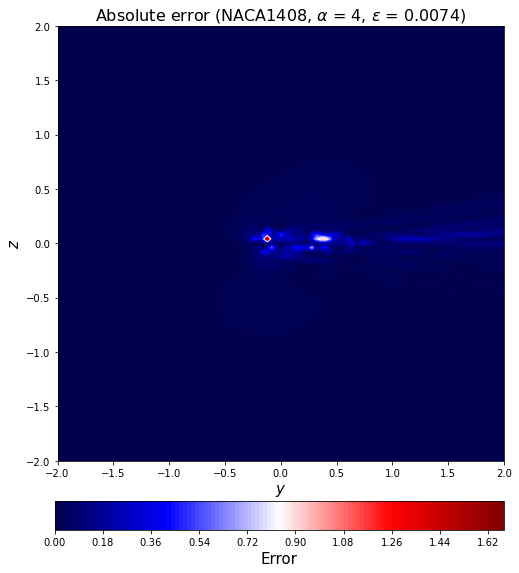

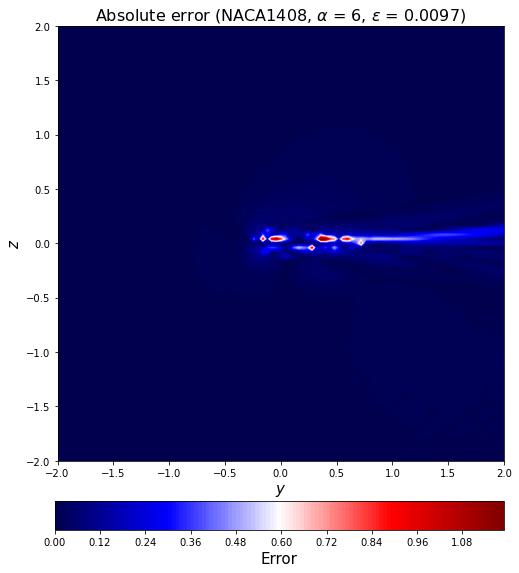

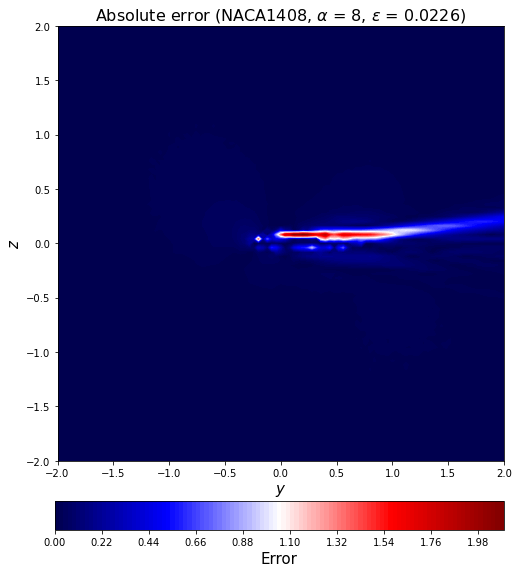

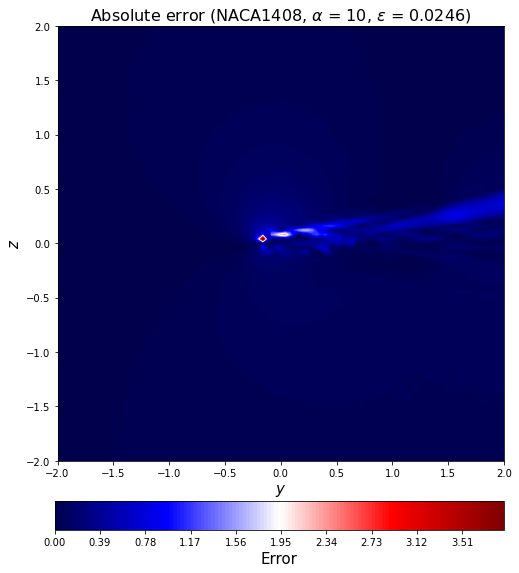

In [87]:
for c in range(0,11):
    error_train_abs2_rotate = error_train_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[c])[3:-2],
                                                                             aa_train[c], l2_error_train_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[c])[3:-2])+str(aa_train[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

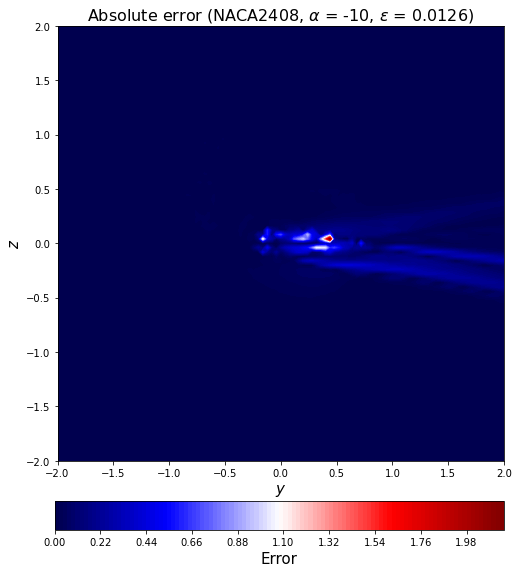

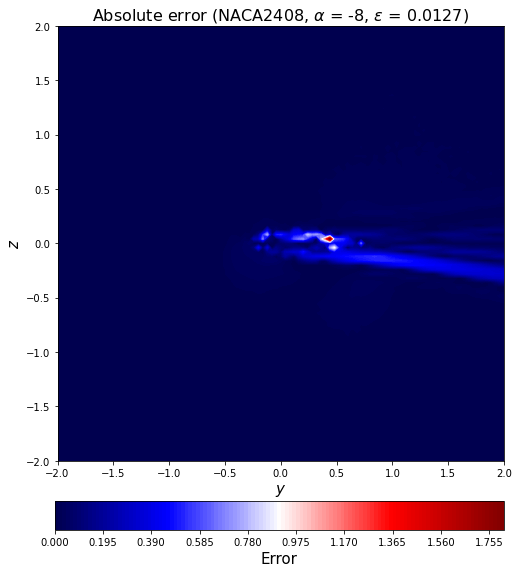

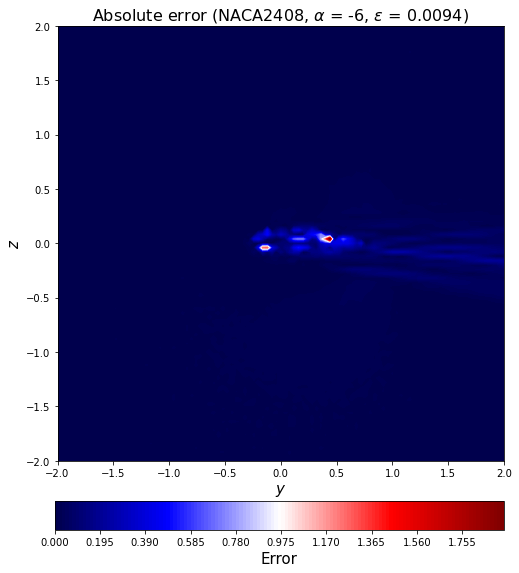

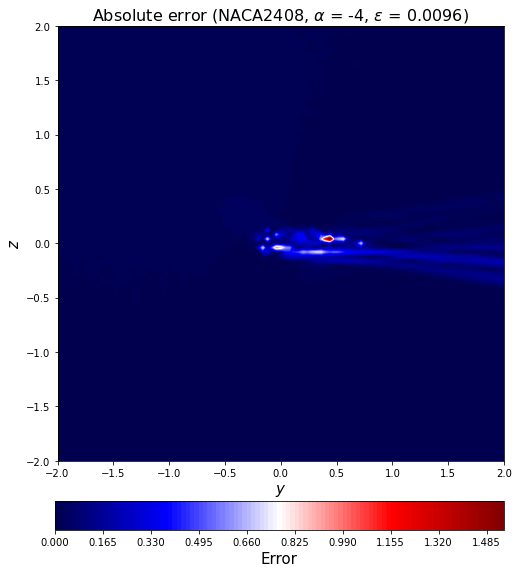

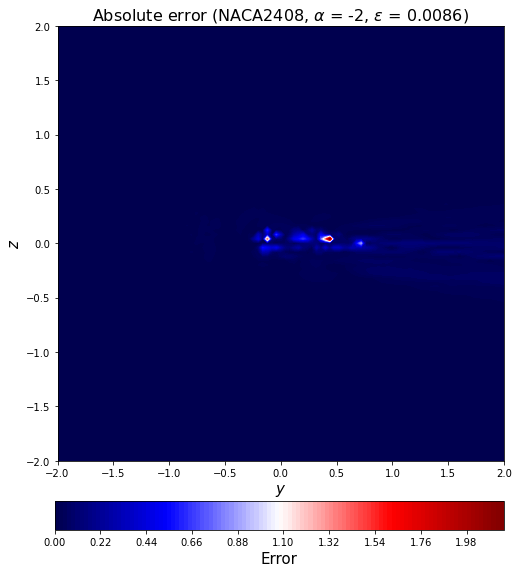

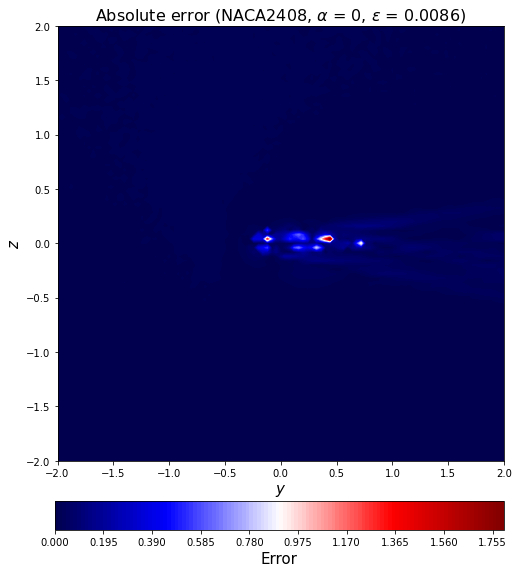

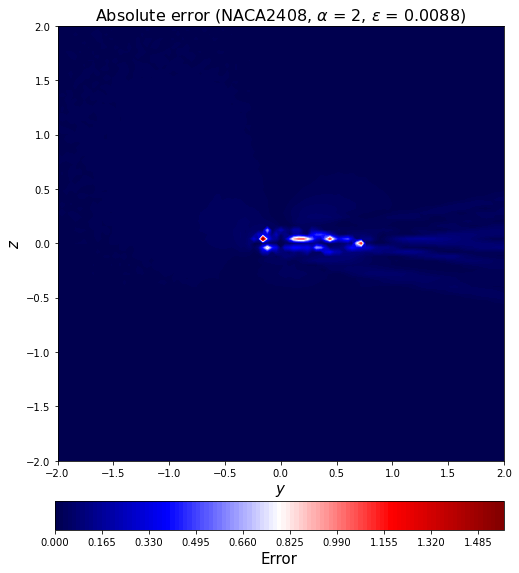

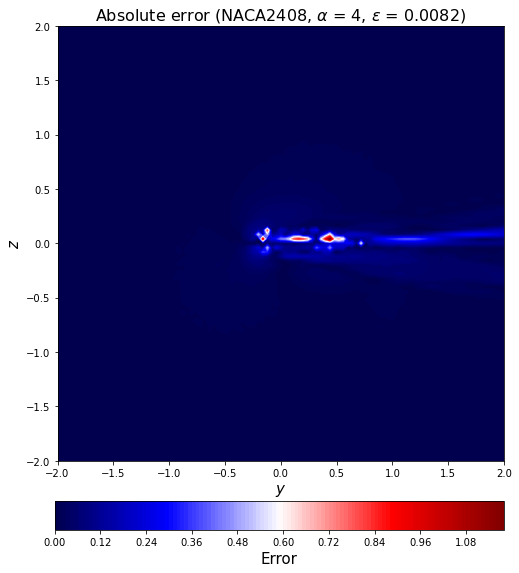

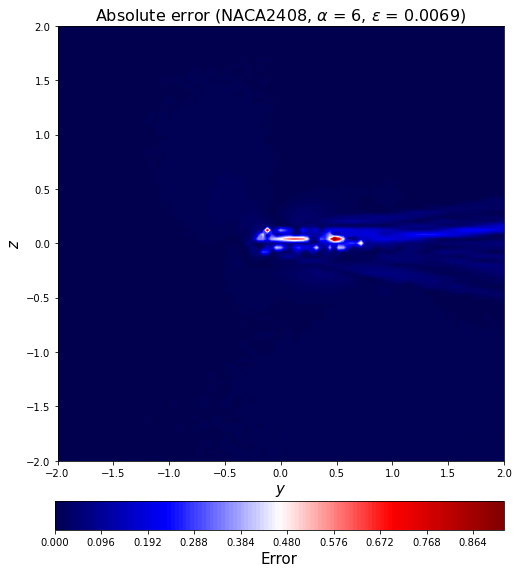

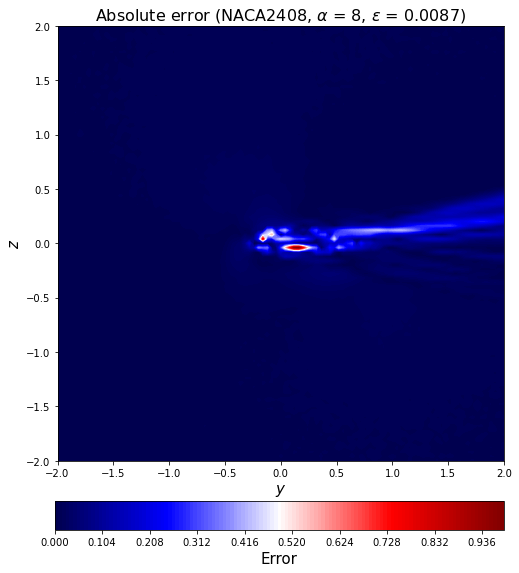

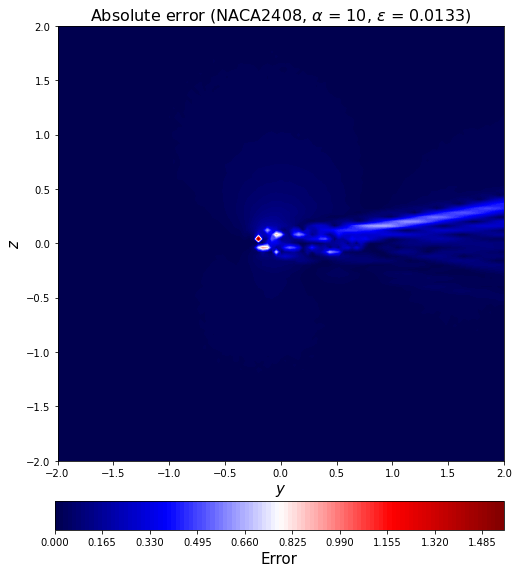

In [88]:
for c in range(0,11):
    error_train_abs2_rotate = error_train_abs[11*20+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[11*20+c])[3:-2],
                                                                             aa_train[11*20+c], l2_error_train_list[11*20+c]),fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[11*20+c])[3:-2])+str(aa_train[11*20+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()